<a href="https://colab.research.google.com/github/vvviet2908/DA-ML/blob/main/Census_Income_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Name: Vo Van Viet - ID: ITDSIU18043**

# A Data Pipeline for Classification Analysis 
This is for the practice on 
- Data Cleaning 
- Feature Engineering 
- Imputation
- Classification.


### You can import some Standard Python Libraries for use

In [ ]:
import io, os, sys, types, time, datetime, math, random, requests, subprocess, StringIO, tempfile

## Packages Install

We'll now install a few more libraries for crawling data and checking missing values

In [ ]:
!pip install missingno
!pip install requests

## Packages Import

These are all the packages we'll be using

In [ ]:
# Data Manipulation 
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

# Feature Selection and Encoding
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning 
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf

# Grid and Random Search
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plot the Figures Inline
%matplotlib inline

## Listing Installed Packages

We could list all installed packages to check whether a package has already been installed.

## Objective

In this lab, you are required to use the Census Income Dataset to predict whether an individual's income exceeds $50K/yr based on census data.

The dataset can be found here: https://archive.ics.uci.edu/ml/datasets/adult

## Data Download and Loading

Let's download the data and save it to a folder in our local directory called `dataset`. Download it once, and then comment the code out for subsequent runs.

After downloading the data, we load it directly from Disk into a Pandas Dataframe in Memory. 

The data comes separated into the Training and Test datasets. We will join the two for data exploration, and then separate them again before running our algorithms.

But, first of all, you need to mount the content to your Drive

In [ ]:
# Download
DATASET = (
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
)

def download_data(path='./dataset', urls=DATASET):
    if not os.path.exists(path):
        os.mkdir(path)

    for url in urls:
        response = requests.get(url)
        name = os.path.basename(url)
        with open(os.path.join(path, name), 'w') as f:
            f.write(response.content)

download_data()

In [ ]:
# Load Training and Test Data Sets
headers = ['age', 'workclass', 'fnlwgt', 
           'education', 'education-num', 
           'marital-status', 'occupation', 
           'relationship', 'race', 'sex', 
           'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 
           'predclass']
training_raw = pd.read_csv('dataset/adult.data', 
                       header=None, 
                       names=headers, 
                       sep=',\s', 
                       na_values=["?"], 
                       engine='python')
test_raw = pd.read_csv('dataset/adult.test', 
                      header=None, 
                      names=headers, 
                      sep=',\s', 
                      na_values=["?"], 
                      engine='python', 
                      skiprows=1)

In [ ]:
# Join Datasets
dataset_raw = training_raw.append(test_raw)
dataset_raw.reset_index(inplace=True)
dataset_raw.drop('index',inplace=True,axis=1)

## Data Exploration - Univariate

When exploring our dataset and its features, we have many options available to us. We can explore each feature individually, or compare pairs of features, finding the correlation between. Let's start with some simple Univariate (one feature) analysis.

Features can be of multiple types:
- **Nominal:**  is for mutual exclusive, but not ordered, categories.
- **Ordinal:** is one where the order matters but not the difference between values.
- **Interval:** is a measurement where the difference between two values is meaningful.
- **Ratio:** has all the properties of an interval variable, and also has a clear definition of 0.0.

There are multiple ways of manipulating each feature type, but for simplicity, we'll define only two feature types:
- **Numerical:** any feature that contains numeric values.
- **Categorical:** any feature that contains categories, or text.

### 1. Describing all the Numerical Features

In [ ]:
# Describing all the Numerical Features
dataset_raw.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


### 2. Describing all the Categorical Features

In [ ]:
# Describing all the Categorical Features
dataset_raw.describe(include=['O'])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,predclass
count,46043,48842,48842,46033,48842,48842,48842,47985,48842
unique,8,16,7,14,6,5,2,41,4
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,24720


### 3. Let's have a quick look at our data using `head()`

In [ ]:
# Let's have a quick look at our data
dataset_raw.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,predclass
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### 4. Let’s write a function to plot the distribution of each feature, depending on the type of feature. For more detail, if the feature has type `object`, you use countplot from seaborn, else you use displot from seaborn as well.

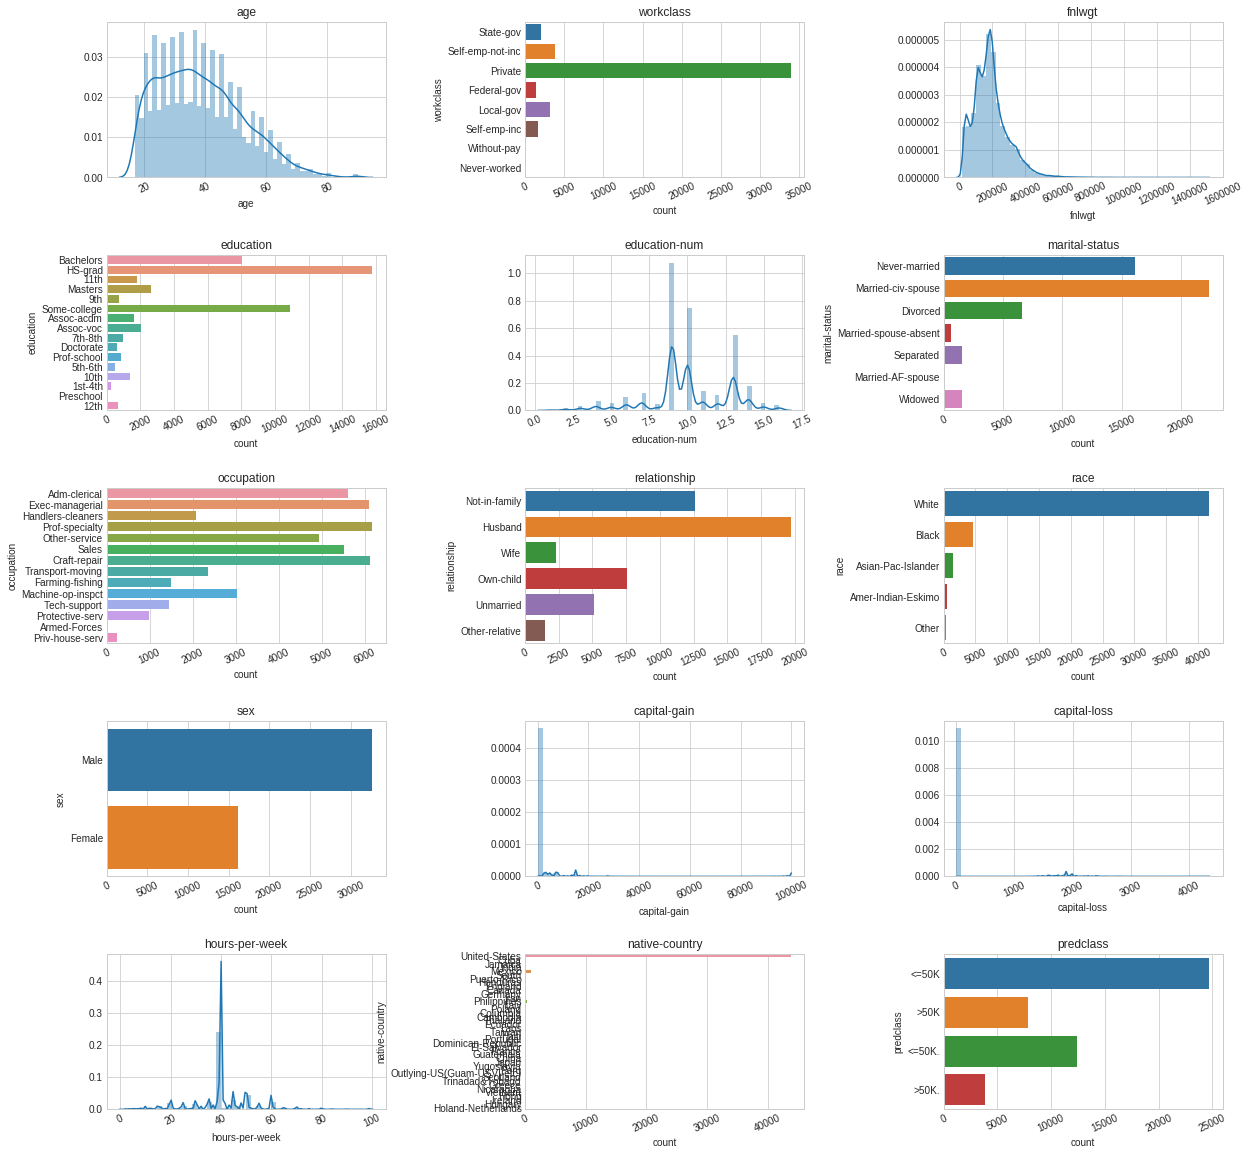

In [ ]:
def plot_distribution(dataset, cols=5, width = 20, height=15, hspace=0.2, wspace=0.5):
  plt.style.use('seaborn-whitegrid')
  fig= plt.figure(figsize=(width,height))
  fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
  rows= math.ceil(float(dataset.shape[1])/cols)
  for i, column in enumerate(dataset.columns):
    ax= fig.add_subplot(rows, cols, i+1)
    ax.set_title(column)
    if dataset.dtypes[column]==np.object:
      g= sns.countplot(y=column, data=dataset)
      #substrings = [s.set_text()[:18] for s in g.get_yticklabels()]
      #g.set(yticklabels=substrings)
      plt.xticks(rotation=25)
    else:
      g= sns.distplot(dataset[column])
      plt.xticks(rotation=25)

plot_distribution(dataset_raw, cols=3, width=20, height=20, hspace=0.5, wspace=0.5)

### 5. Using `missingno` to answer the question: How many missing values are there in our dataset?

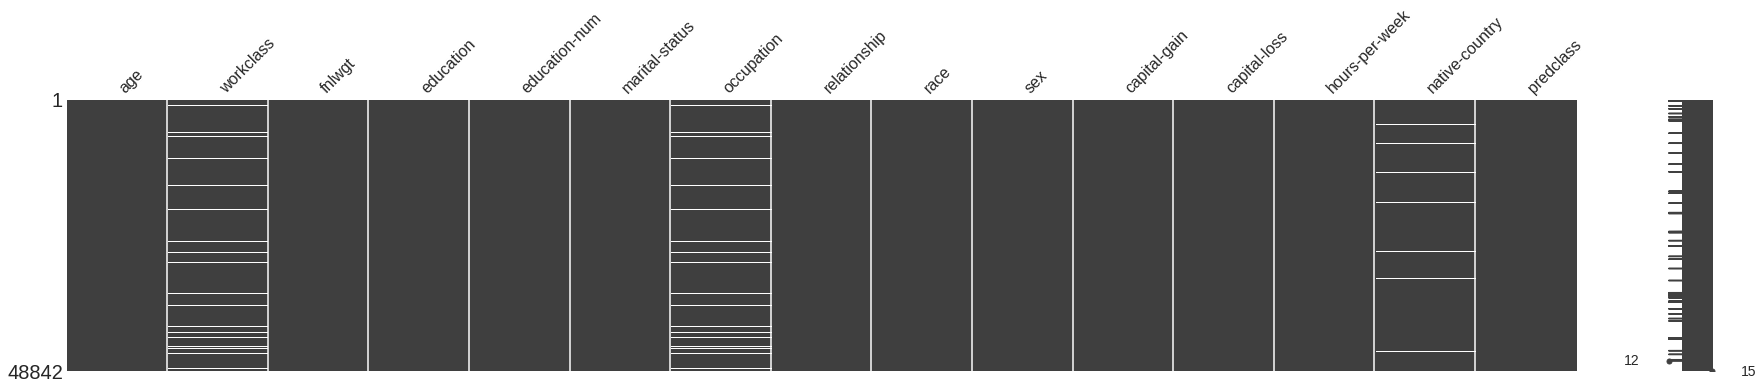

In [ ]:
# How many missing values are there in our dataset?
missingno.matrix(dataset_raw, figsize=(30,5))

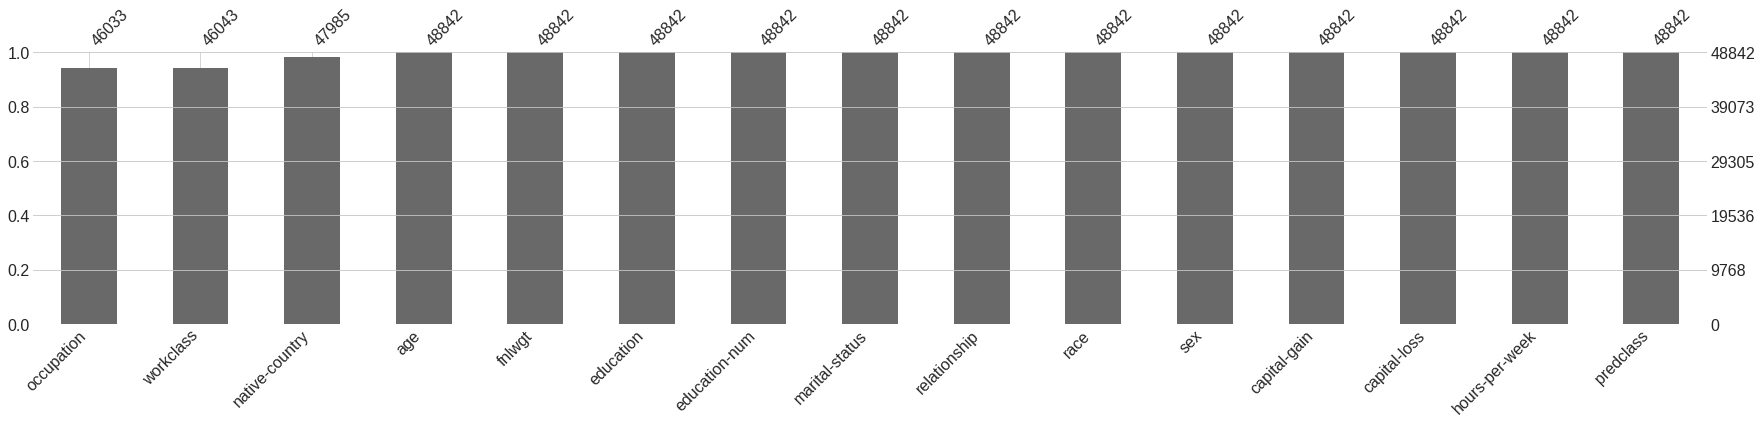

In [ ]:
missingno.bar(dataset_raw, sort='ascending', figsize=(30,5))

# Feature Cleaning, Engineering, and Imputation

**Cleaning:**
To clean our data, we'll need to work with:

- **Missing values:** Either omit elements from a dataset that contain missing values or impute them (fill them in).
- **Special values:** Numeric variables are endowed with several formalized special values including ±Inf, NA and NaN. Calculations involving special values often result in special values, and need to be handled/cleaned.
- **Outliers:** They should be detected, but not necessarily removed. Their inclusion in the analysis is a statistical decision.
- **Obvious inconsistencies:** A person's age cannot be negative, a man cannot be pregnant and an under-aged person cannot possess a drivers license. Find the inconsistencies and plan for them.

**Engineering:**
There are multiple techniques for feature engineering:
- **Decompose:** Converting 2014-09-20T20:45:40Z into categorical attributes like hour_of_the_day, part_of_day, etc.
- **Discretization:** We can choose to either discretize some of the continuous variables we have, as some algorithms will perform faster. We are going to do both, and compare the results of the ML algorithms on both discretized and non discretised datasets. We'll call these datasets:

- dataset_bin => where Continuous variables are Discretised
- dataset_con => where Continuous variables are Continuous 

- **Reframe Numerical Quantities:** Changing from grams to kg, and losing detail might be both wanted and efficient for calculation
- **Feature Crossing:** Creating new features as a combination of existing features. Could be multiplying numerical features, or combining categorical variables. This is a great way to add domain expertise knowledge to the dataset.
    
**Imputation:**
We can impute missing values in a number of different ways:
- **Hot-Deck:**	The technique then finds the first missing value and uses the cell value immediately prior to the data that are missing to impute the missing value.
- **Cold-Deck:** Selects donors from another dataset to complete missing data.
- **Mean-substitution:** Another imputation technique involves replacing any missing value with the mean of that variable for all other cases, which has the benefit of not changing the sample mean for that variable.
- **Regression:** A regression model is estimated to predict observed values of a variable based on other variables, and that model is then used to impute values in cases where that variable is missing.

In [ ]:
# To perform our data analysis, let's create new dataframes.
dataset_bin = pd.DataFrame() # To contain our dataframe with our discretised continuous variables 
dataset_con = pd.DataFrame() # To contain our dataframe with our continuous variables 

### Feature Predclass

This is the feature we are trying to predict. We'll change the string to a binary 0/1. With 1 signifying over $50K.

### 6. Let's fix the Class Feature using `loc` from `pandas`

In [ ]:
# Let's fix the Class Feature
dataset_raw.loc[dataset_raw['predclass']== '>50K', 'predclass'] = 1
dataset_raw.loc[dataset_raw['predclass']== '>50K.', 'predclass'] = 1
dataset_raw.loc[dataset_raw['predclass']== '<=50K', 'predclass'] = 0
dataset_raw.loc[dataset_raw['predclass']== '<=50K.', 'predclass'] = 0

dataset_bin['predclass']= dataset_raw['predclass']
dataset_con['predclass'] = dataset_raw['predclass']

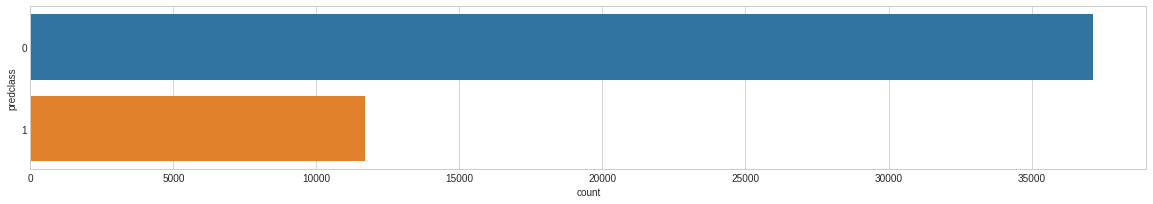

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3))
sns.countplot(y="predclass", data=dataset_bin);

### Feature: Age

### 7. In this task, we will use the Pandas Cut function (`pd.cut`) to bin the data in equally sized buckets (`dataset_bin`) (let's say 10 buckets). We will also add our original feature to the `dataset_con` dataframe.

In [ ]:
dataset_bin['age']=pd.cut(dataset_raw['age'], 10)
dataset_con['age']=dataset_raw['age']

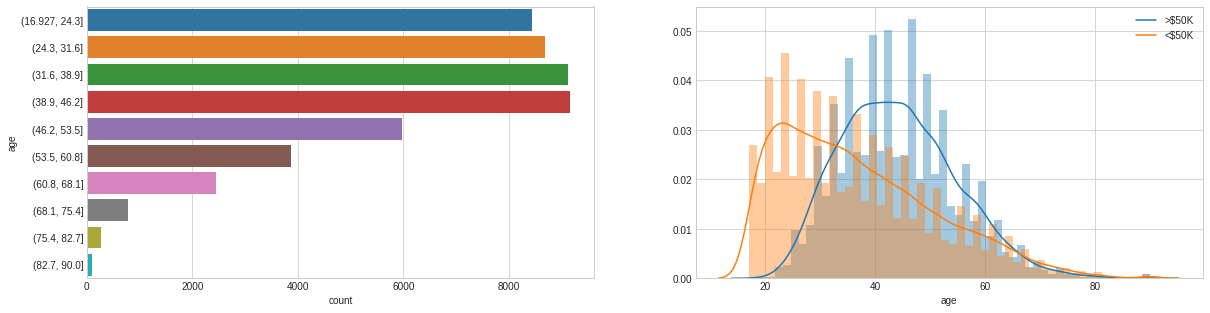

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5)) 
plt.subplot(1, 2, 1)
sns.countplot(y="age", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 1]['age'], kde_kws={"label": ">$50K"});
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 0]['age'], kde_kws={"label": "<$50K"});

### Feature: Workclass

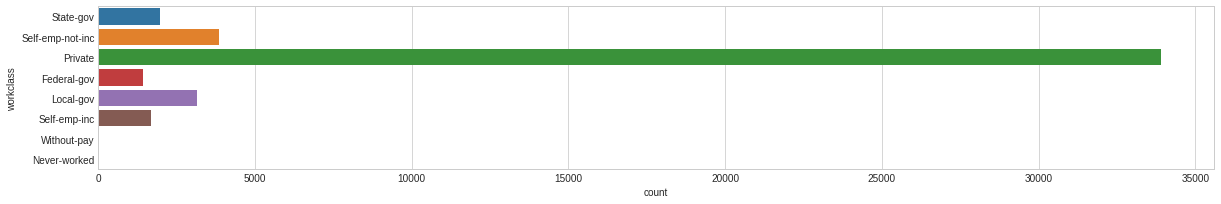

In [ ]:
# For example, can we bucket groups for `workclass`?
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,3)) 
sns.countplot(y="workclass", data=dataset_raw);

In [ ]:
# There are too many groups here, we can group some of them together.
# Create buckets for Workclass
dataset_raw.loc[dataset_raw['workclass'] == 'Without-pay', 'workclass'] = 'Not Working'
dataset_raw.loc[dataset_raw['workclass'] == 'Never-worked', 'workclass'] = 'Not Working'
dataset_raw.loc[dataset_raw['workclass'] == 'Federal-gov', 'workclass'] = 'Fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == 'State-gov', 'workclass'] = 'Non-fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == 'Local-gov', 'workclass'] = 'Non-fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == 'Self-emp-not-inc', 'workclass'] = 'Self-emp'
dataset_raw.loc[dataset_raw['workclass'] == 'Self-emp-inc', 'workclass'] = 'Self-emp'

dataset_bin['workclass'] = dataset_raw['workclass']
dataset_con['workclass'] = dataset_raw['workclass']

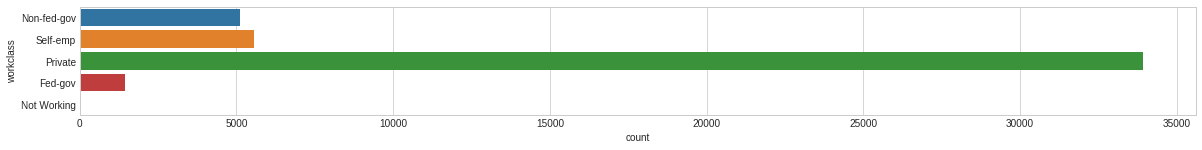

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,2)) 
sns.countplot(y="workclass", data=dataset_bin);

### Feature: Occupation

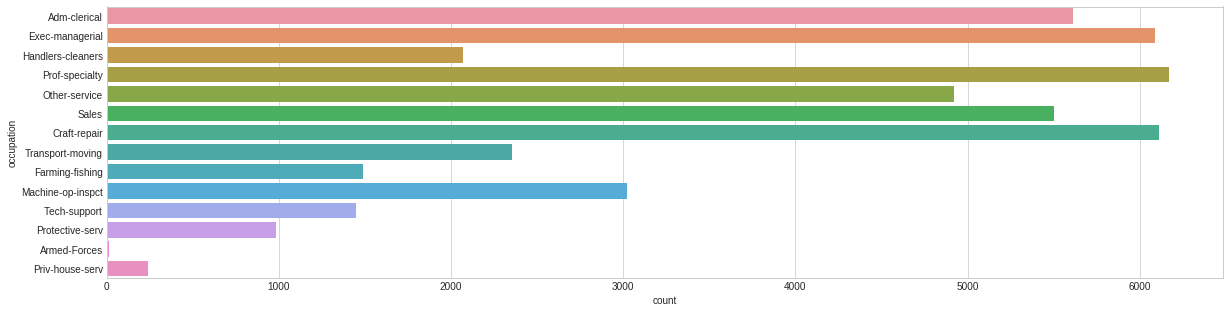

In [ ]:
# Can we bucket some of these groups?
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5)) 
sns.countplot(y="occupation", data=dataset_raw);

In [ ]:
# Create buckets for Occupation
dataset_raw.loc[dataset_raw['occupation'] == 'Adm-clerical', 'occupation'] = 'Admin'
dataset_raw.loc[dataset_raw['occupation'] == 'Armed-Forces', 'occupation'] = 'Military'
dataset_raw.loc[dataset_raw['occupation'] == 'Craft-repair', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Exec-managerial', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Farming-fishing', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Handlers-cleaners', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Machine-op-inspct', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Other-service', 'occupation'] = 'Service'
dataset_raw.loc[dataset_raw['occupation'] == 'Priv-house-serv', 'occupation'] = 'Service'
dataset_raw.loc[dataset_raw['occupation'] == 'Prof-specialty', 'occupation'] = 'Professional'
dataset_raw.loc[dataset_raw['occupation'] == 'Protective-serv', 'occupation'] = 'Military'
dataset_raw.loc[dataset_raw['occupation'] == 'Sales', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Tech-support', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Transport-moving', 'occupation'] = 'Manual Labour'

dataset_bin['occupation'] = dataset_raw['occupation']
dataset_con['occupation'] = dataset_raw['occupation']

### 8. Similarly, plot new groups of `Occupation`

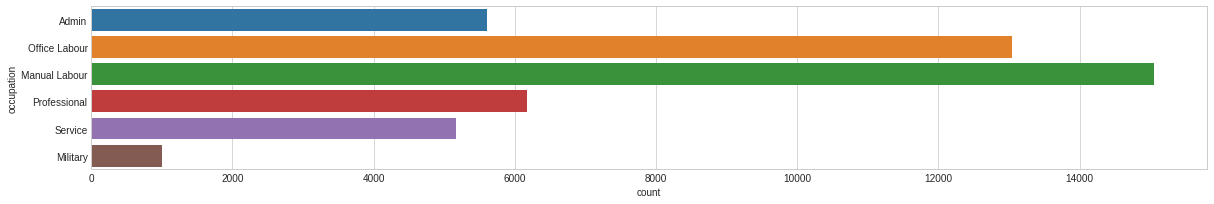

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,3)) 
sns.countplot(y="occupation", data=dataset_bin)

### Feature: Native Country

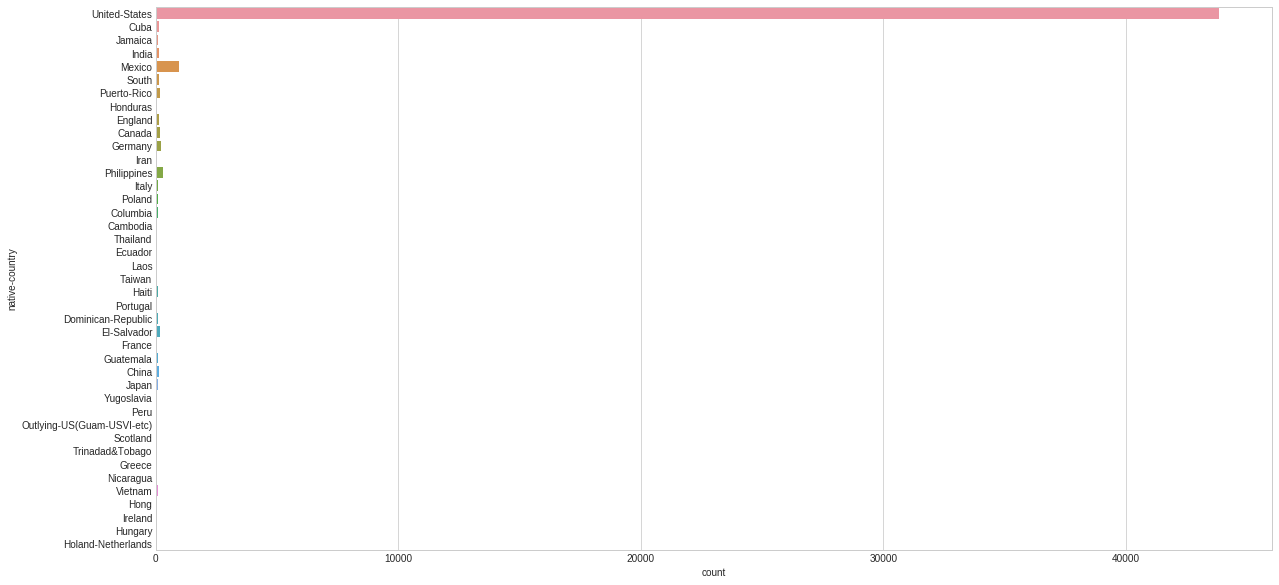

In [ ]:
# Can we bucket some of these groups?
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,10)) 
sns.countplot(y="native-country", data=dataset_raw);

In [ ]:
dataset_raw.loc[dataset_raw['native-country'] == 'Cambodia'                    , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Canada'                      , 'native-country'] = 'British-Commonwealth'    
dataset_raw.loc[dataset_raw['native-country'] == 'China'                       , 'native-country'] = 'China'       
dataset_raw.loc[dataset_raw['native-country'] == 'Columbia'                    , 'native-country'] = 'South-America'    
dataset_raw.loc[dataset_raw['native-country'] == 'Cuba'                        , 'native-country'] = 'South-America'        
dataset_raw.loc[dataset_raw['native-country'] == 'Dominican-Republic'          , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Ecuador'                     , 'native-country'] = 'South-America'     
dataset_raw.loc[dataset_raw['native-country'] == 'El-Salvador'                 , 'native-country'] = 'South-America' 
dataset_raw.loc[dataset_raw['native-country'] == 'England'                     , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'France'                      , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Germany'                     , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Greece'                      , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Guatemala'                   , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Haiti'                       , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Holand-Netherlands'          , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Honduras'                    , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Hong'                        , 'native-country'] = 'China'
dataset_raw.loc[dataset_raw['native-country'] == 'Hungary'                     , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'India'                       , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'Iran'                        , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Ireland'                     , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'Italy'                       , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Jamaica'                     , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Japan'                       , 'native-country'] = 'APAC'
dataset_raw.loc[dataset_raw['native-country'] == 'Laos'                        , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Mexico'                      , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Nicaragua'                   , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Outlying-US(Guam-USVI-etc)'  , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Peru'                        , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Philippines'                 , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Poland'                      , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Portugal'                    , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Puerto-Rico'                 , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Scotland'                    , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'South'                       , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Taiwan'                      , 'native-country'] = 'China'
dataset_raw.loc[dataset_raw['native-country'] == 'Thailand'                    , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Trinadad&Tobago'             , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'United-States'               , 'native-country'] = 'United-States'
dataset_raw.loc[dataset_raw['native-country'] == 'Vietnam'                     , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Yugoslavia'                  , 'native-country'] = 'Euro_Group_2'

dataset_bin['native-country'] = dataset_raw['native-country']
dataset_con['native-country'] = dataset_raw['native-country']

### 9. Similarly, plot new groups of `Native Country`

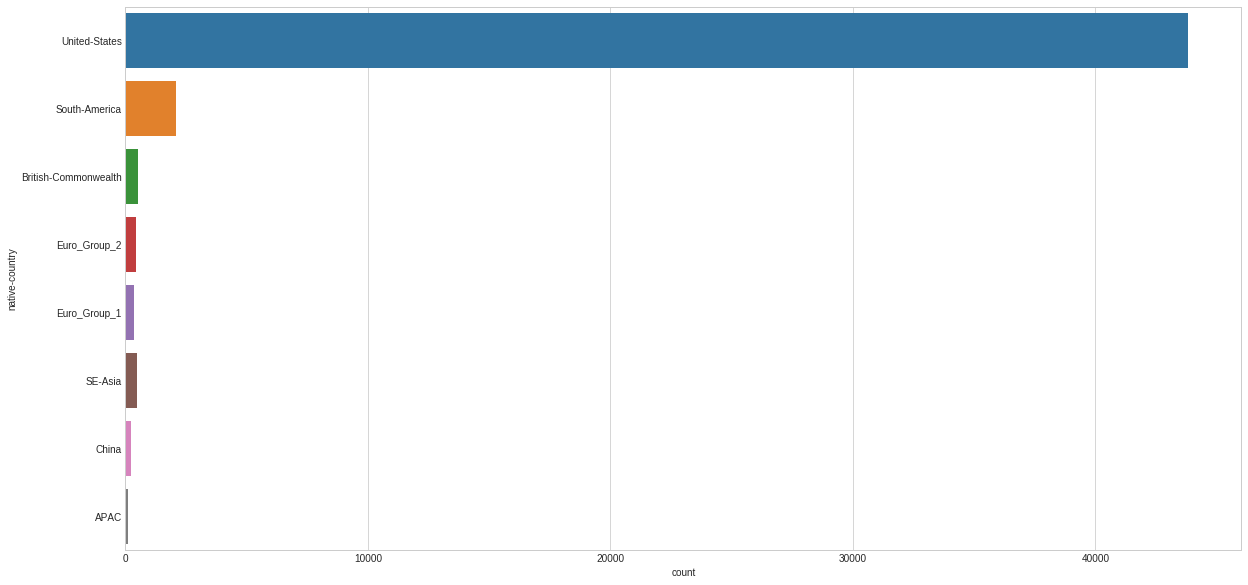

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,10)) 
sns.countplot(y="native-country", data=dataset_raw)

### Feature: Education

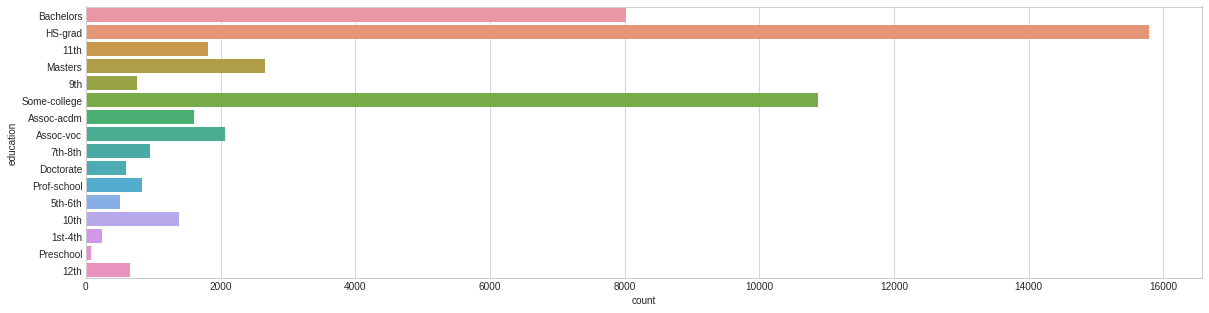

In [ ]:
# Can we bucket some of these groups?
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5)) 
sns.countplot(y="education", data=dataset_raw);

In [ ]:
dataset_raw.loc[dataset_raw['education'] == '10th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '11th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '12th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '1st-4th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '5th-6th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '7th-8th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '9th'           , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == 'Assoc-acdm'    , 'education'] = 'Associate'
dataset_raw.loc[dataset_raw['education'] == 'Assoc-voc'     , 'education'] = 'Associate'
dataset_raw.loc[dataset_raw['education'] == 'Bachelors'     , 'education'] = 'Bachelors'
dataset_raw.loc[dataset_raw['education'] == 'Doctorate'     , 'education'] = 'Doctorate'
dataset_raw.loc[dataset_raw['education'] == 'HS-Grad'       , 'education'] = 'HS-Graduate'
dataset_raw.loc[dataset_raw['education'] == 'Masters'       , 'education'] = 'Masters'
dataset_raw.loc[dataset_raw['education'] == 'Preschool'     , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == 'Prof-school'   , 'education'] = 'Professor'
dataset_raw.loc[dataset_raw['education'] == 'Some-college'  , 'education'] = 'HS-Graduate'

dataset_bin['education'] = dataset_raw['education']
dataset_con['education'] = dataset_raw['education']

### 10. Similarly, plot new groups of `Education`

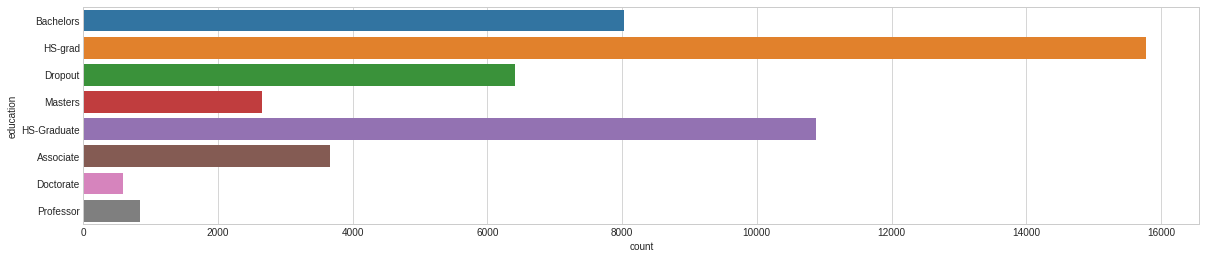

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,4)) 
sns.countplot(y="education", data=dataset_bin)

### Feature: Marital Status

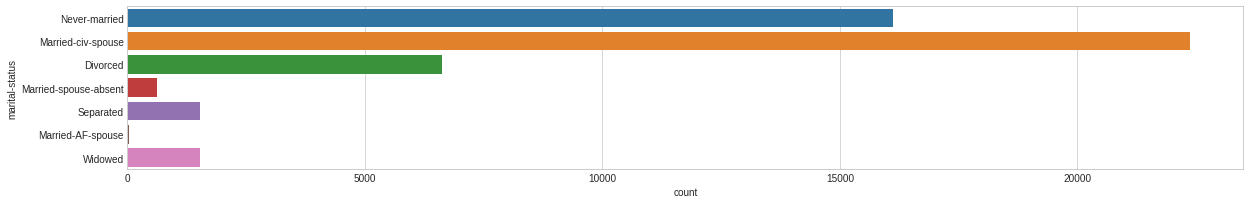

In [ ]:
# Can we bucket some of these groups?
plt.figure(figsize=(20,3)) 
sns.countplot(y="marital-status", data=dataset_raw);

In [ ]:
dataset_raw.loc[dataset_raw['marital-status'] == 'Never-married'        , 'marital-status'] = 'Never-Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Married-AF-spouse'    , 'marital-status'] = 'Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Married-civ-spouse'   , 'marital-status'] = 'Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Married-spouse-absent', 'marital-status'] = 'Not-Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Separated'            , 'marital-status'] = 'Separated'
dataset_raw.loc[dataset_raw['marital-status'] == 'Divorced'             , 'marital-status'] = 'Separated'
dataset_raw.loc[dataset_raw['marital-status'] == 'Widowed'              , 'marital-status'] = 'Widowed'

dataset_bin['marital-status'] = dataset_raw['marital-status']
dataset_con['marital-status'] = dataset_raw['marital-status']

### 11. Similarly, plot new groups of `Marital Status`

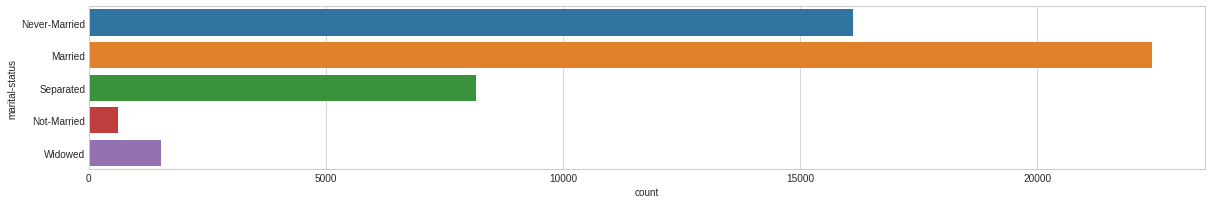

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,3)) 
sns.countplot(y="marital-status", data=dataset_bin)

### Feature: Final Weight

### 12. Similarly, for `Final Weight`, let's use the Pandas Cut function to bin the data in equally sized buckets (10 buckets)

In [ ]:
# Let's use the Pandas Cut function to bin the data in equally sized buckets
dataset_bin['fnlwgt']=pd.cut(dataset_raw['fnlwgt'], 10)
dataset_con['fnlwgt']=dataset_raw['fnlwgt']

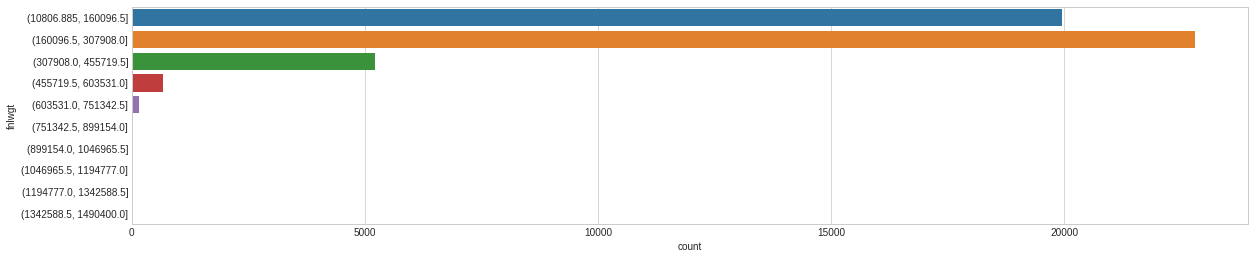

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.countplot(y="fnlwgt", data=dataset_bin);

### Feature: Education Number

### 13. Similarly, for `Education Number`, let's use the Pandas Cut function to bin the data in equally sized buckets (10 buckets)

In [ ]:
# Let's use the Pandas Cut function to bin the data in equally sized buckets
dataset_bin['education-num']=pd.cut(dataset_raw['education-num'], 10)
dataset_con['education-num']=dataset_raw['education-num']

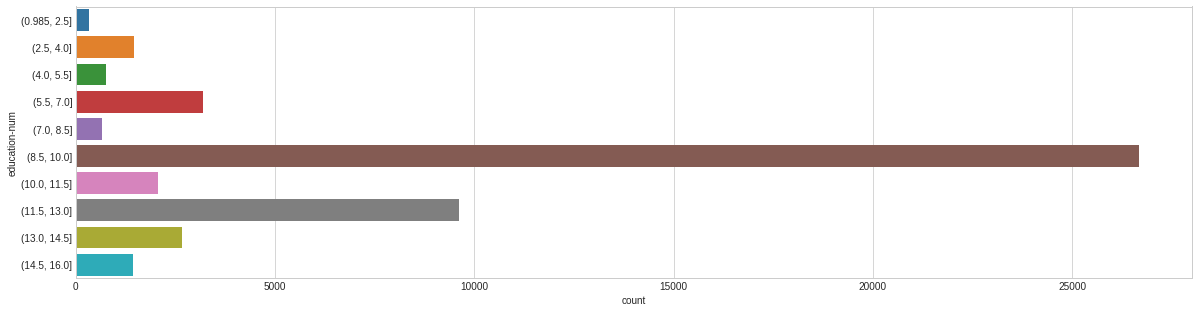

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5)) 
sns.countplot(y="education-num", data=dataset_bin);

### Feature: Hours per Week

### 14. Similarly, for `Hours per Week`, let's use the Pandas Cut function to bin the data in equally sized buckets (10 buckets)

In [ ]:
# Let's use the Pandas Cut function to bin the data in equally sized buckets
dataset_bin['hours-per-week']=pd.cut(dataset_raw['hours-per-week'], 10)
dataset_con['hours-per-week']=dataset_raw['hours-per-week']

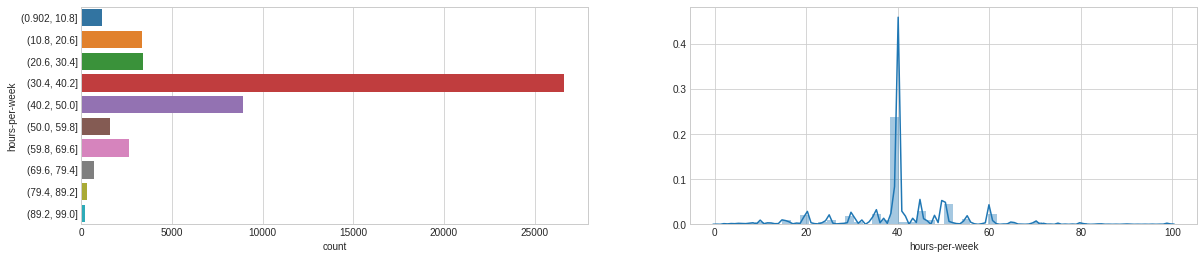

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
plt.subplot(1, 2, 1)
sns.countplot(y="hours-per-week", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['hours-per-week']);

### Feature: Capital Gain

### 15. Similarly, for `Capital Gain`, let's use the Pandas Cut function to bin the data in equally sized buckets (5 buckets), and plot the new `capital-gain`

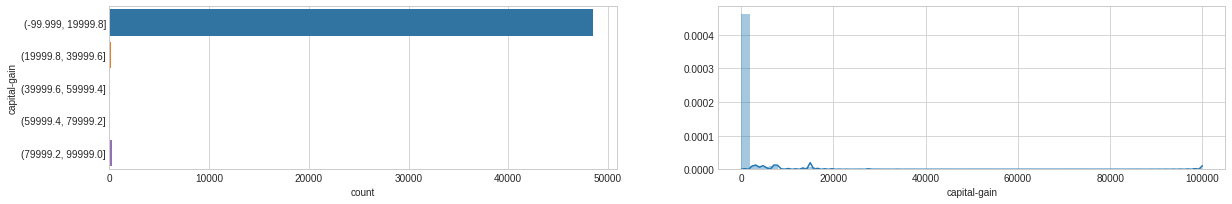

In [ ]:
# Let's use the Pandas Cut function to bin the data in equally sized buckets
dataset_bin['capital-gain']=pd.cut(dataset_raw['capital-gain'], 5)
dataset_con['capital-gain']=dataset_raw['capital-gain']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3)) 
plt.subplot(1, 2, 1)
sns.countplot(y="capital-gain", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['capital-gain']);

### Feature: Capital Loss

### 16. Similarly, for `Capital Loss`, let's use the Pandas Cut function to bin the data in equally sized buckets (5 buckets), and plot the new `capital-loss` as in the figure

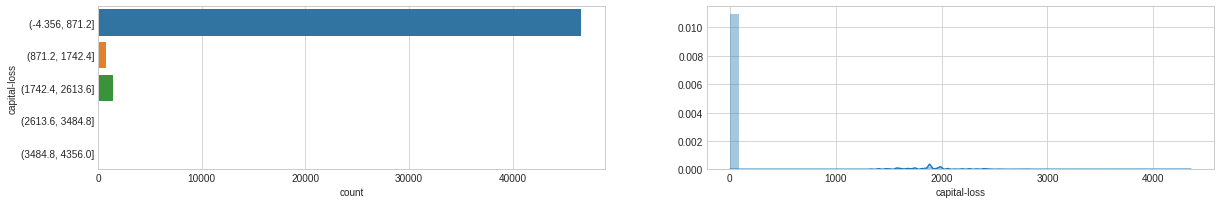

In [ ]:
# Let's use the Pandas Cut function to bin the data in equally sized buckets
dataset_bin['capital-loss']=pd.cut(dataset_raw['capital-loss'], 5)
dataset_con['capital-loss']=dataset_raw['capital-loss']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3)) 
plt.subplot(1, 2, 1)
sns.countplot(y="capital-loss", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['capital-loss']);

### Features: Race, Sex, Relationship

### 17. Some features we'll consider to be in good enough shape as to pass through `dataset_con`, they are Race, Sex, Relationship. So, please do this pass.

In [ ]:
# Some features we'll consider to be in good enough shape as to pass through
dataset_con['sex'] = dataset_bin['sex'] = dataset_raw['sex']
dataset_con['race'] = dataset_bin['race'] = dataset_raw['race']
dataset_con['relationship'] = dataset_bin['relationship'] = dataset_raw['relationship']

## Bi-variate Analysis

So far, we have analized all features individually. Let's now start combining some of these features together to obtain further insight into the interactions between them via Bi-variate plot. To do so, plot a count of the categories from each categorical feature split by our prediction class: `salary` - `predclass`.

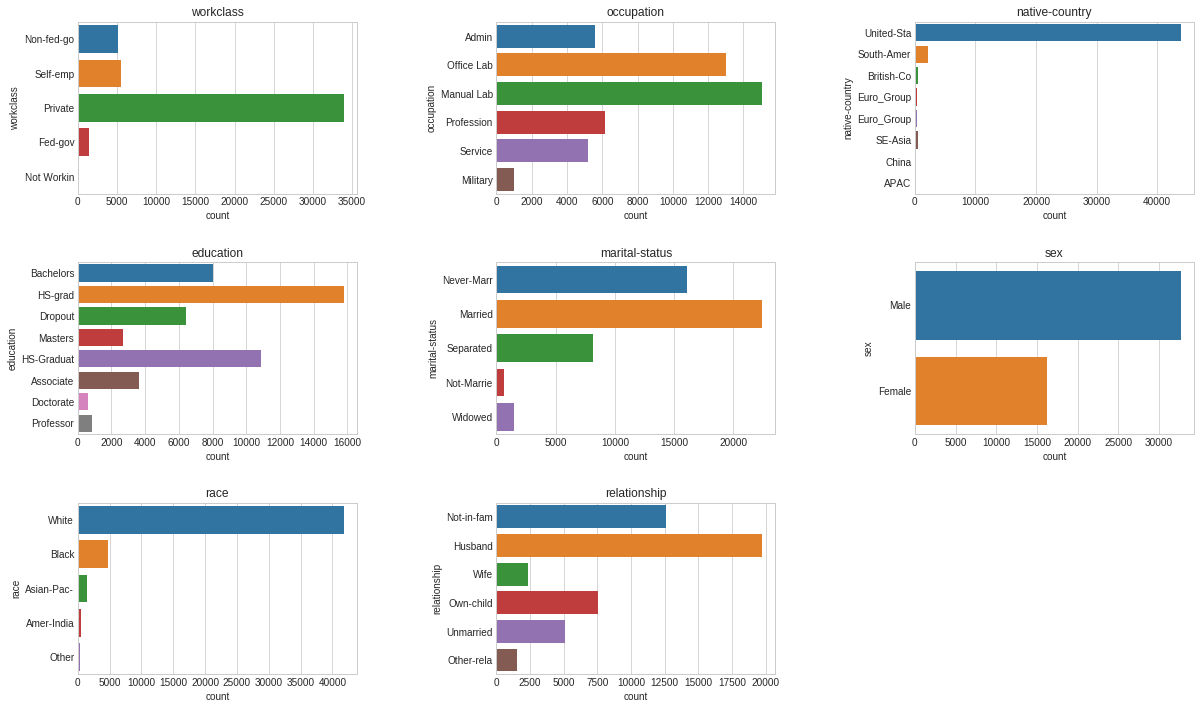

In [ ]:
# Plot a count of the categories from each categorical feature split by our prediction class: salary - predclass.
def plot_bivariate_bar(dataset, hue, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    dataset = dataset.select_dtypes(include=[np.object])
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, hue=hue, data=dataset)
            substrings = [s.get_text()[:10] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            
plot_bivariate_bar(dataset_con, hue=None , cols=3, width=20, height=12, hspace=0.4, wspace=0.5)

### 18. Using `FacetGrid` to show the effect of `Marital Status` and `Education` on `Income`, across `Marital Status`

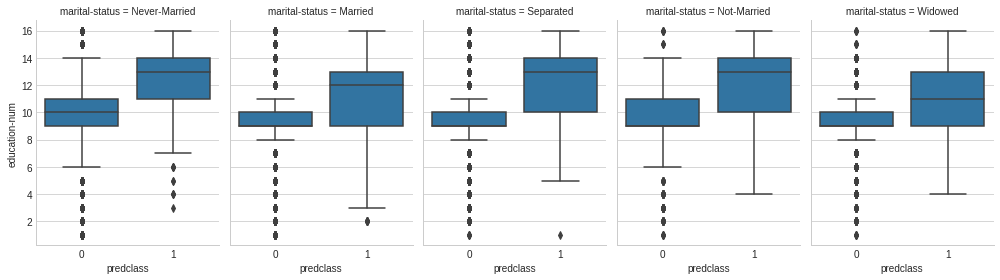

In [ ]:
# Effect of Marital Status and Education on Income, across Marital Status.
plt.style.use('seaborn-whitegrid')
g = sns.FacetGrid(dataset_con, col='marital-status', size=4, aspect=.7)
g = g.map(sns.boxplot, 'predclass', 'education-num')

### 19. Show historical Trends on the `Sex`, `Education`, `HPW` and `Age` impact on `Income`, using `violinplot`.

2

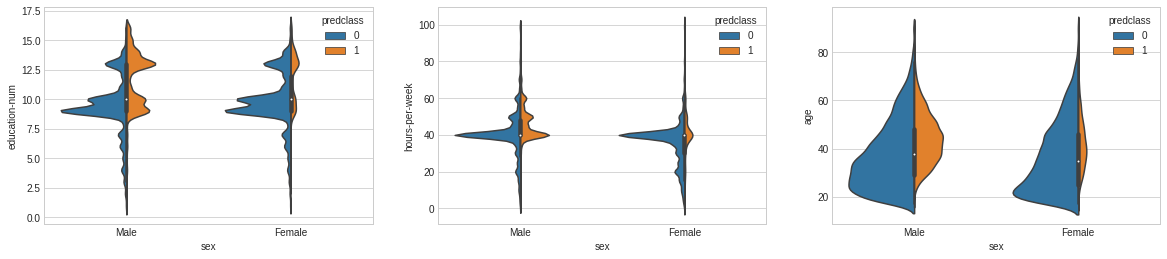

In [ ]:
# Historical Trends on the Sex, Education, HPW and Age impact on Income.
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
sns.violinplot(x='sex', y='education-num', hue='predclass', data=dataset_con, split=True, scale='count');

plt.subplot(1,3,2)
sns.violinplot(x='sex', y='hours-per-week', hue='predclass', data=dataset_con, split=True, scale='count');

plt.subplot(1,3,3)
sns.violinplot(x='sex', y='age', hue='predclass', data=dataset_con, split=True, scale='count');2

### 20. Using `pairplot` to express the interaction between pairs of features

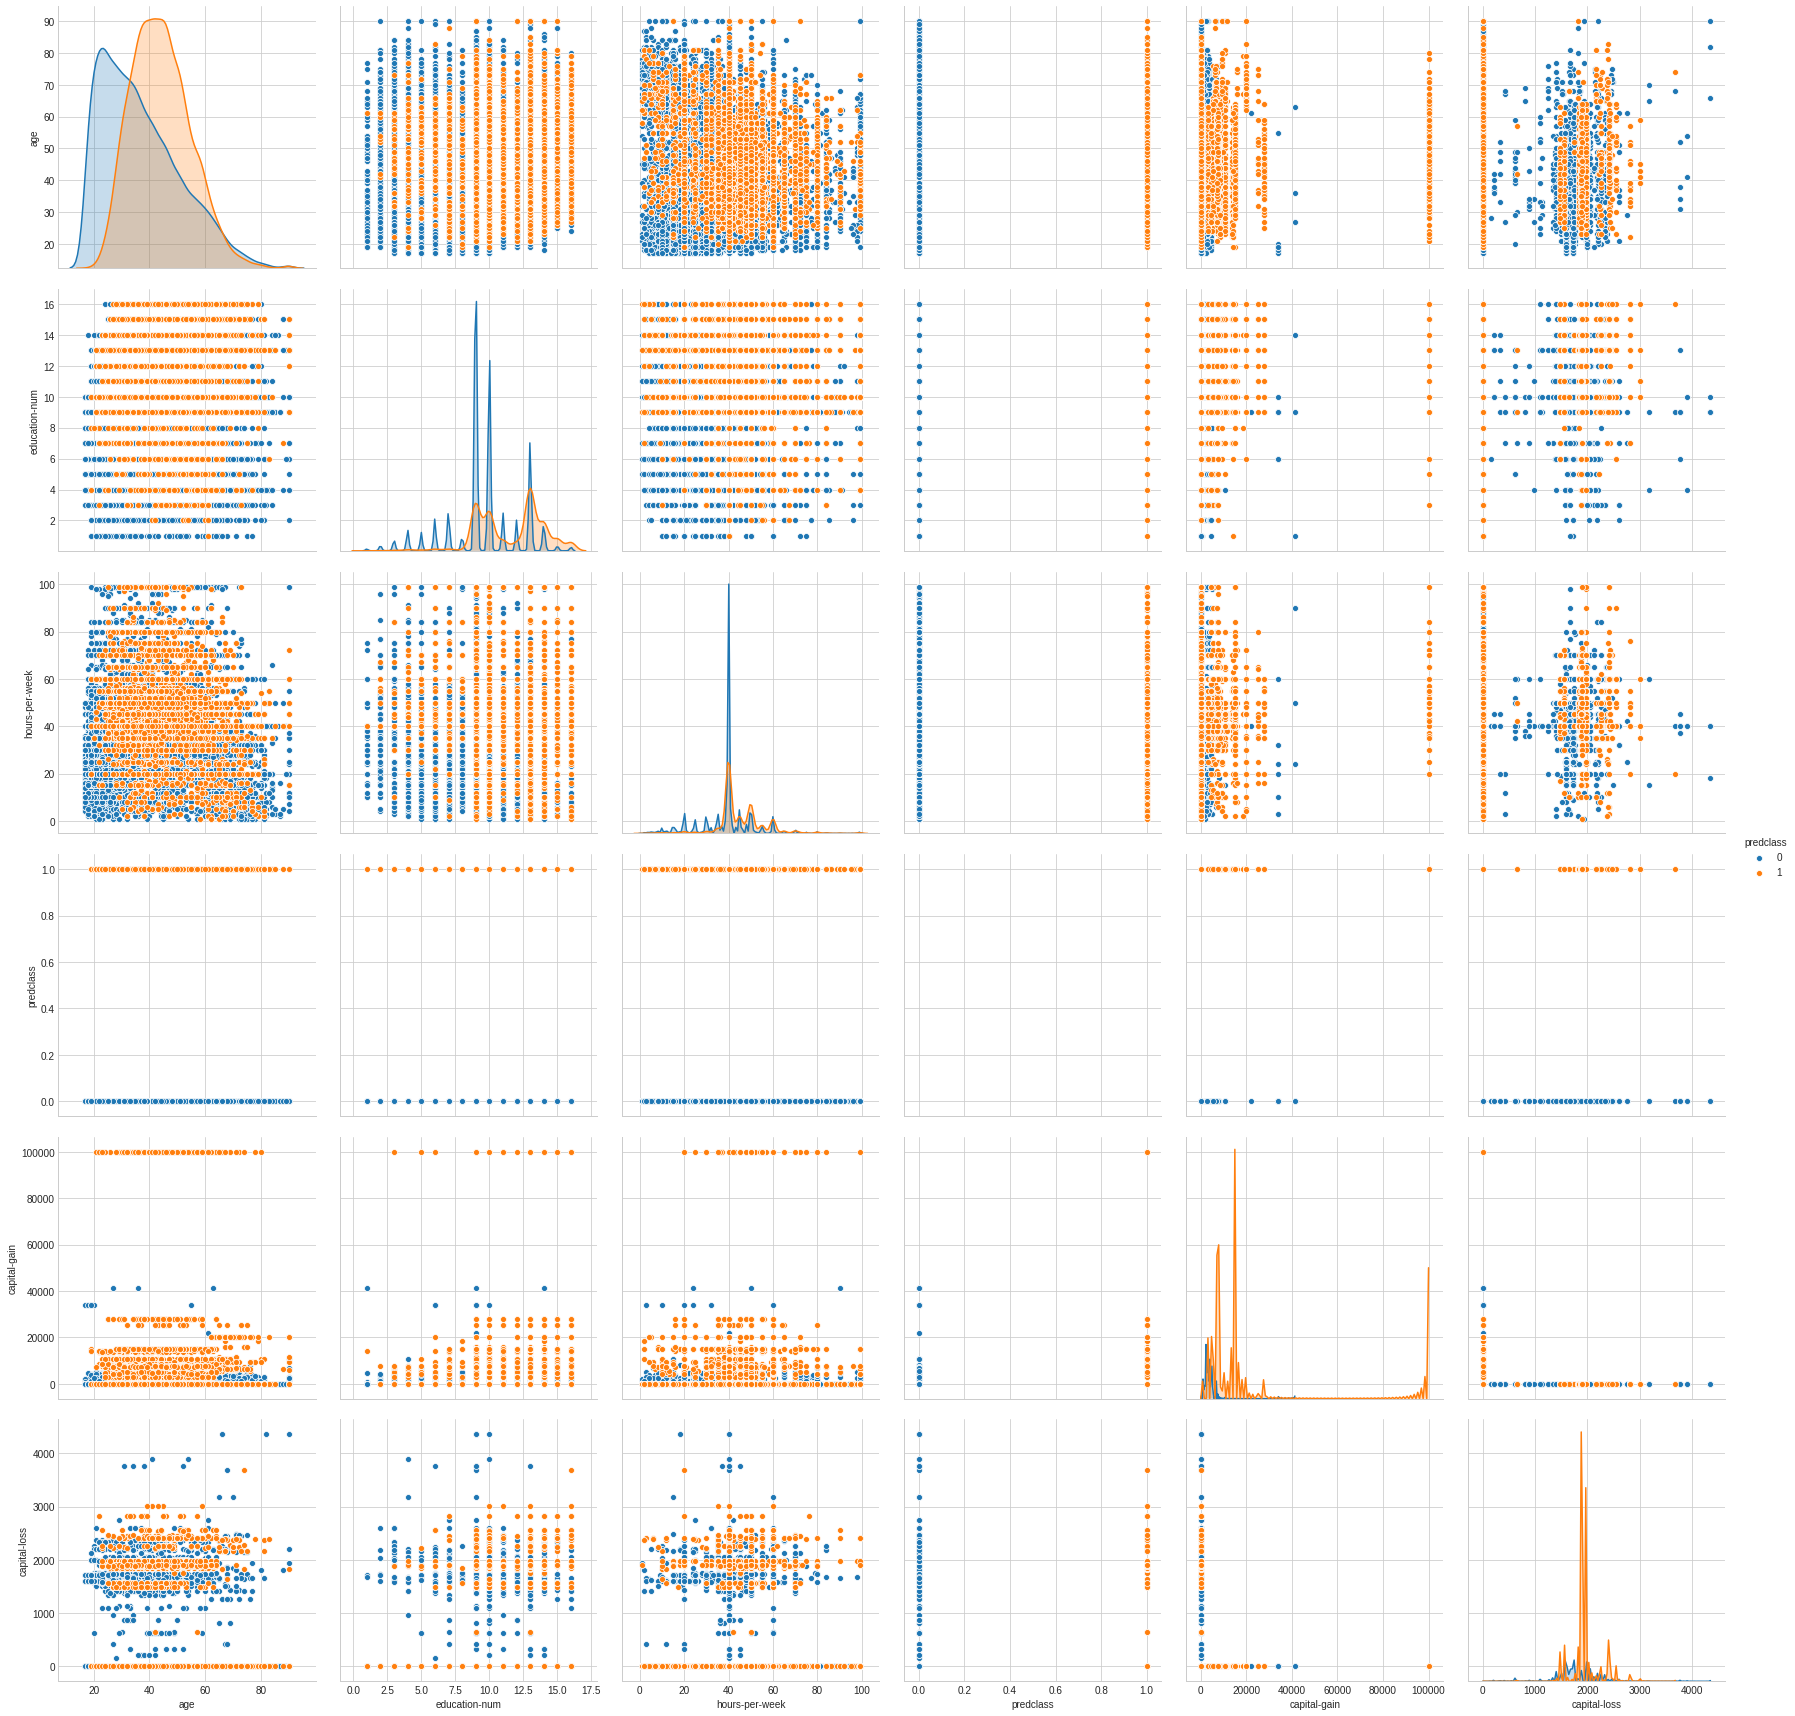

In [ ]:
# Interaction between pairs of features.
sns.pairplot(dataset_con[['age', 'education-num', 'hours-per-week', 'predclass', 'capital-gain', 'capital-loss']],
              hue= 'predclass',
              diag_kind='kde',
              size=4);

## Feature Crossing: Age + Hours Per Week

So far, we have modified and cleaned features that existed in our dataset. However, we can go further and create a new new variables, adding human knowledge on the interaction between features.

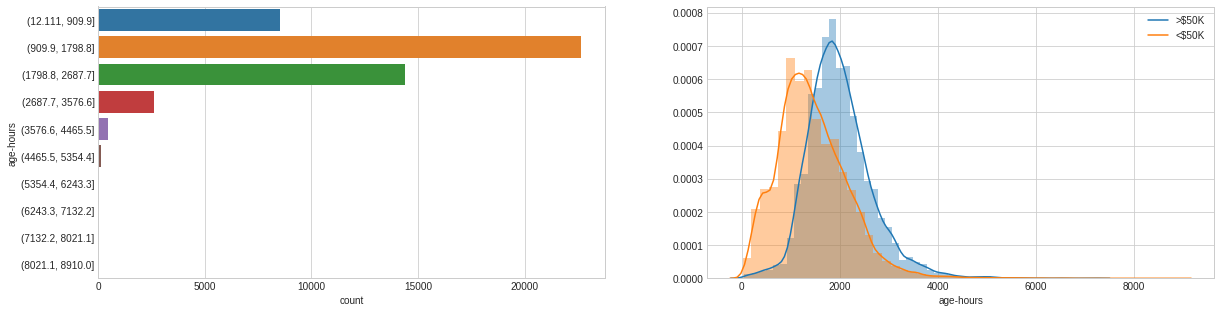

In [ ]:
# Crossing Numerical Features
dataset_con['age-hours'] = dataset_con['age'] * dataset_con['hours-per-week']

dataset_bin['age-hours'] = pd.cut(dataset_con['age-hours'], 10)
dataset_con['age-hours'] = dataset_con['age-hours']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5)) 
plt.subplot(1, 2, 1)
sns.countplot(y="age-hours", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 1]['age-hours'], kde_kws={"label": ">$50K"});
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 0]['age-hours'], kde_kws={"label": "<$50K"});

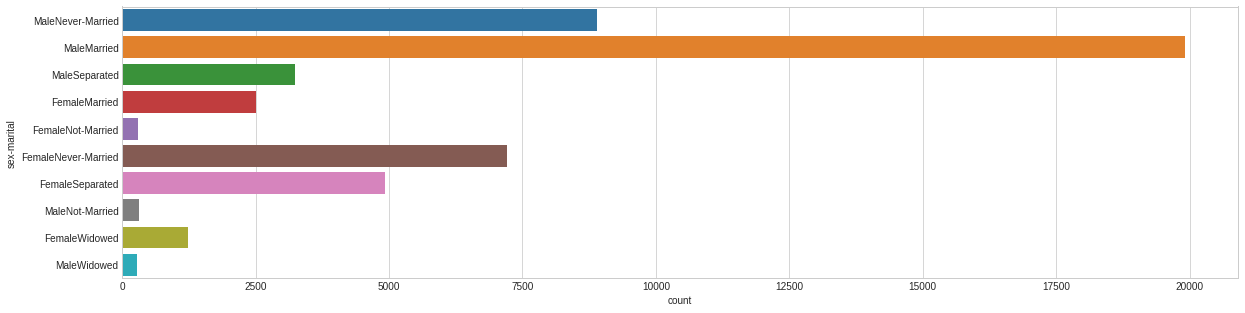

In [ ]:
# Crossing Categorical Features
dataset_bin['sex-marital'] = dataset_con['sex-marital'] = dataset_con['sex'] + dataset_con['marital-status']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5)) 
sns.countplot(y="sex-marital", data=dataset_bin);

## Feature Encoding

Remember that Machine Learning algorithms perform Linear Algebra on Matrices, which means all features need have numeric values. The process of converting Categorical Features into values is called Encoding. Let's perform both One-Hot and Label encoding.

Additional Resources: http://pbpython.com/categorical-encoding.html

### 21. Carry out the One Hot Encodes all labels before Machine Learning, applying to `dataset_bin`, then convert categorical variable into dummy/indicator variables to create `dataset_bin_enc`

In [ ]:
# One Hot Encodes all labels before Machine Learning
one_hot_cols = dataset_bin.columns.tolist()
one_hot_cols.remove('predclass')
dataset_bin_enc=pd.get_dummies(dataset_bin, columns=one_hot_cols)

dataset_bin_enc.head()

,predclass,"age_(16.927, 24.3]","age_(24.3, 31.6]","age_(31.6, 38.9]","age_(38.9, 46.2]","age_(46.2, 53.5]","age_(53.5, 60.8]","age_(60.8, 68.1]","age_(68.1, 75.4]","age_(75.4, 82.7]",...,sex-marital_FemaleMarried,sex-marital_FemaleNever-Married,sex-marital_FemaleNot-Married,sex-marital_FemaleSeparated,sex-marital_FemaleWidowed,sex-marital_MaleMarried,sex-marital_MaleNever-Married,sex-marital_MaleNot-Married,sex-marital_MaleSeparated,sex-marital_MaleWidowed
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### 22. Carry out the Label Encode all labels before Machine Learning, applying to `dataset_con` to create `dataset_con_enc` 

In [ ]:
# Label Encode all labels
dataset_con_enc = dataset_con.apply(LabelEncoder().fit_transform)

dataset_con_enc.head()

,predclass,age,workclass,occupation,native-country,education,marital-status,fnlwgt,education-num,hours-per-week,capital-gain,capital-loss,sex,race,relationship,age-hours,sex-marital
0,0,22,2,1,8,1,1,3461,12,39,27,0,1,4,1,695,6
1,0,33,5,4,8,1,0,3788,12,12,0,0,1,4,0,334,5
2,0,21,4,2,8,5,3,18342,8,39,0,0,1,4,1,683,8
3,0,36,4,2,8,3,0,19995,6,39,0,0,1,2,0,890,5
4,0,11,4,5,7,1,0,25405,12,39,0,0,0,2,5,530,0


## Feature Reduction / Selection

Once we have our features ready to use, we might find that the number of features available is too large to be run in a reasonable timeframe by our machine learning algorithms. There's a number of options available to us for feature reduction and feature selection.

- **Dimensionality Reduction:**
    - **Principal Component Analysis (PCA):** Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components.
    - **Singular Value Decomposition (SVD):** SVD is a factorization of a real or complex matrix. It is the generalization of the eigendecomposition of a positive semidefinite normal matrix (for example, a symmetric matrix with positive eigenvalues) to any m×n  matrix via an extension of the polar decomposition. It has many useful applications in signal processing and statistics.


- **Feature Importance/Relevance:**
    - **Filter Methods:** Filter type methods select features based only on general metrics like the correlation with the variable to predict. Filter methods suppress the least interesting variables. The other variables will be part of a classification or a regression model used to classify or to predict data. These methods are particularly effective in computation time and robust to overfitting.
    - **Wrapper Methods:** Wrapper methods evaluate subsets of variables which allows, unlike filter approaches, to detect the possible interactions between variables. The two main disadvantages of these methods are : The increasing overfitting risk when the number of observations is insufficient. AND. The significant computation time when the number of variables is large.
    - **Embedded Methods:** Embedded methods try to combine the advantages of both previous methods. A learning algorithm takes advantage of its own variable selection process and performs feature selection and classification simultaneously.

### Feature Correlation

Correlation ia s measure of how much two random variables change together. Features should be uncorrelated with each other and highly correlated to the feature we’re trying to predict.

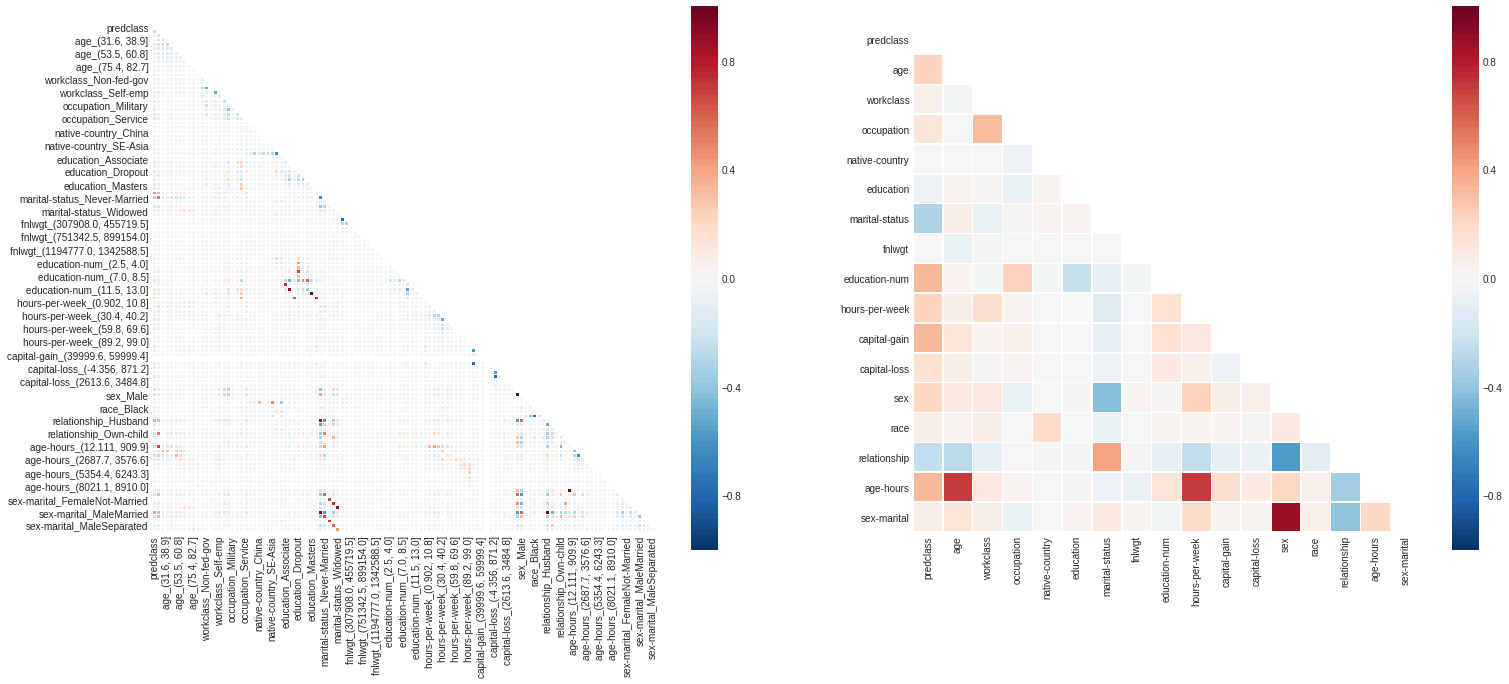

In [ ]:
# Create a correlation plot of both datasets.
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(25,10)) 

plt.subplot(1, 2, 1)
# Generate a mask for the upper triangle
mask = np.zeros_like(dataset_bin_enc.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_bin_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);

plt.subplot(1, 2, 2)
mask = np.zeros_like(dataset_con_enc.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_con_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);

### Feature Importance

Random forest consists of a number of decision trees. Every node in the decision trees is a condition on a single feature, designed to split the dataset into two so that similar response values end up in the same set. The measure based on which the (locally) optimal condition is chosen is called impurity. When training a tree, it can be computed how much each feature decreases the weighted impurity in a tree. For a forest, the impurity decrease from each feature can be averaged and the features are ranked according to this measure. This is the feature importance measure exposed in sklearn’s Random Forest implementations.

### 23. Using Random Forest to gain an insight on Feature Importance from `dataset_con_enc` (plot and rank the Feature Importance)

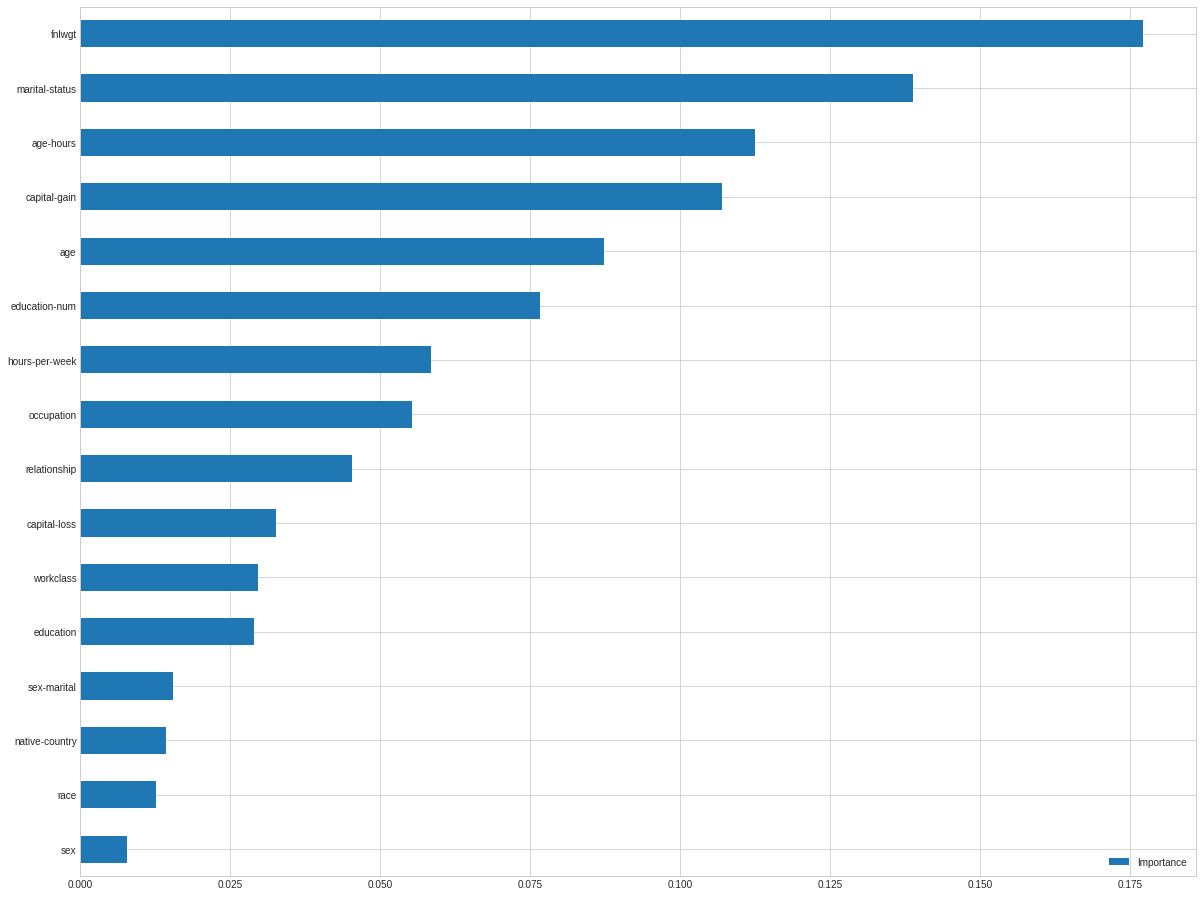

In [ ]:
# Using Random Forest to gain an insight on Feature Importance
clf = RandomForestClassifier()
clf.fit(dataset_con_enc.drop('predclass',axis=1), dataset_con_enc['predclass'])

plt.style.use('seaborn-whitegrid')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=dataset_con_enc.drop('predclass', axis= 1).columns,columns=['Importance'])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)))

### PCA

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components.

We can use PCA to reduce the number of features to use in our ML algorithms, and graphing the variance gives us an idea of how many features we really need to represent our dataset fully.

### 24. Calculating PCA for both datasets, and graphing the Variance for each feature, per dataset (`dataset_bin_enc`, `dataset_con_enc`)

<BarContainer object of 15 artists>

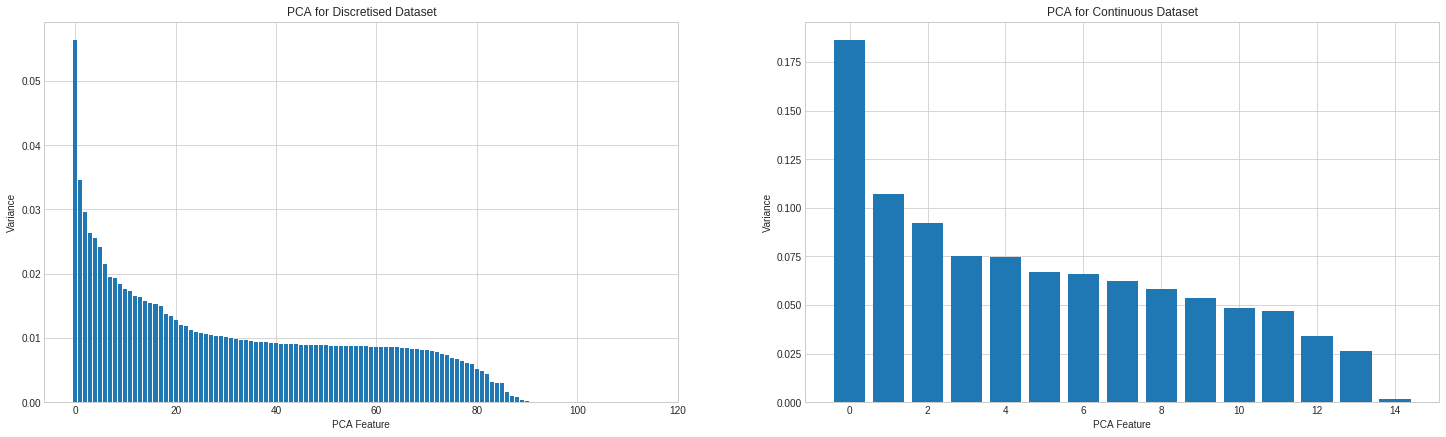

In [ ]:
# Calculating PCA for both datasets, and graphing the Variance for each feature, per dataset
std_scale= preprocessing.StandardScaler().fit(dataset_bin_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_bin_enc.drop('predclass', axis=1))
pca1=PCA(n_components=len(dataset_bin_enc.columns)-1)
fit1= pca1.fit(X)

std_scale= preprocessing.StandardScaler().fit(dataset_con_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_con_enc.drop('predclass', axis=1))
pca2=PCA(n_components=len(dataset_con_enc.columns)-2)
fit2= pca2.fit(X)

# Graphing the variance per feature
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(25,7))

plt.subplot(1,2,1)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Discretised Dataset')
plt.bar(range(0, fit1.explained_variance_ratio_.size), fit1.explained_variance_ratio_)

plt.subplot(1,2,2)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Continuous Dataset')
plt.bar(range(0, fit2.explained_variance_ratio_.size), fit2.explained_variance_ratio_)

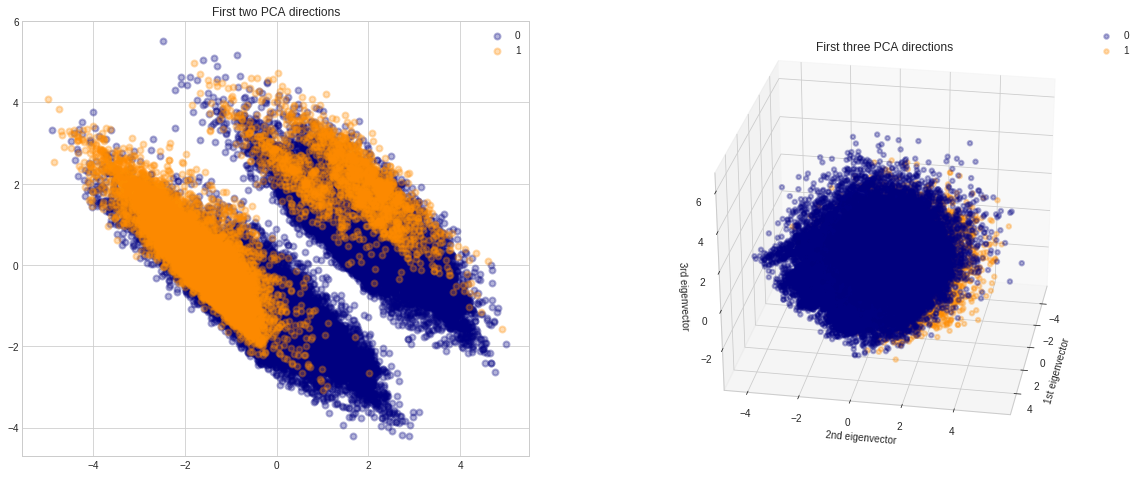

In [ ]:
# RUn this code
# PCA's components graphed in 2D and 3D
# Apply Scaling 
std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_con_enc.drop('predclass', axis=1))
y = dataset_con_enc['predclass']

# Formatting
target_names = [0,1]
colors = ['navy','darkorange']
lw = 2
alpha = 0.3
# 2 Components PCA
plt.style.use('seaborn-whitegrid')
plt.figure(2, figsize=(20, 8))

plt.subplot(1, 2, 1)
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], 
                color=color, 
                alpha=alpha, 
                lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('First two PCA directions');

# 3 Components PCA
ax = plt.subplot(1, 2, 2, projection='3d')

pca = PCA(n_components=3)
X_reduced = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], X_reduced[y == i, 2], 
               color=color,
               alpha=alpha,
               lw=lw, 
               label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")

# rotate the axes
ax.view_init(30, 10)

### Recursive Feature Elimination

Feature ranking with recursive feature elimination and cross-validated selection of the best number of features.

### 25. Calculating RFE for non-discretised dataset, and graphing the Importance for each feature, applying to `dataset_con_enc`

Feature Ranking For Non-Discretised: [1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1]
Optimal number of features: 15


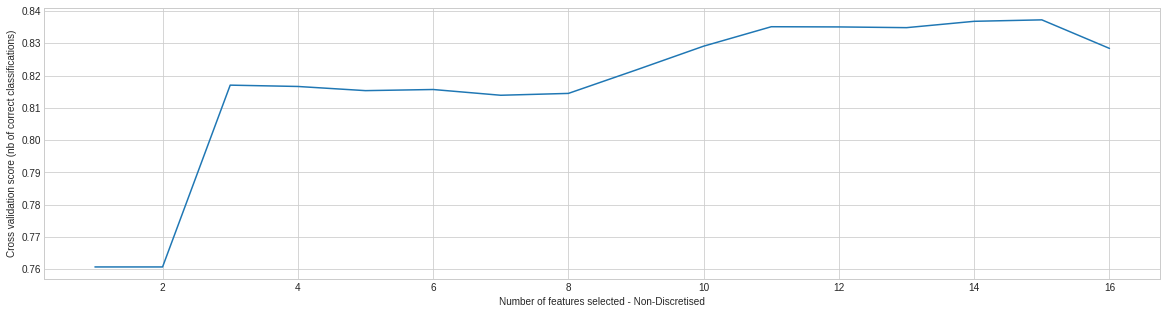

In [ ]:
# Calculating RFE for non-discretised dataset, and graphing the Importance for each feature, per dataset
selector1= RFECV(LogisticRegression(), step=1, cv=5, n_jobs=-1)
selector1= selector1.fit(dataset_con_enc.drop('predclass', axis=1).values, dataset_con_enc['predclass'])
print("Feature Ranking For Non-Discretised: %s" % selector1.ranking_)
print("Optimal number of features: %d" % selector1.n_features_)
# Plot number of features VS. cross-validation scores
plt.style.use('seaborn-whitegrid')
plt.figure(2, figsize=(20, 5))
plt.xlabel("Number of features selected - Non-Discretised")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector1.grid_scores_)+1), selector1.grid_scores_);
# Feature space could be subsetted like so:
dataset_con_enc = dataset_con_enc[dataset_con_enc.columns[np.insert(selector1.support_, 0, True)]]

## Selecting Dataset

We now have two datasets to choose from to apply our ML algorithms. The one-hot-encoded, and the label-encoded. For now, we have decided not to use feature reduction or selection algorithms.

In [ ]:
# OPTIONS: 
# - dataset_bin_enc
# - dataset_con_enc

# Change the dataset to test how would the algorithms perform under a differently encoded dataset.

selected_dataset = dataset_con_enc

In [ ]:
selected_dataset.head(2)

,predclass,age,workclass,occupation,native-country,education,marital-status,education-num,hours-per-week,capital-gain,capital-loss,sex,race,relationship,age-hours,sex-marital
0,0,22,2,1,8,1,1,12,39,27,0,1,4,1,695,6
1,0,33,5,4,8,1,0,12,12,0,0,1,4,0,334,5


## Splitting Data into Training and Testing Datasets

We need to split the data back into the training and testing datasets. Remember we joined both right at the beginning.

### 26. Splitting the Training and Test data sets

In [ ]:
# Splitting the Training and Test data sets
train = selected_dataset.loc[0:32560,:]
test = selected_dataset.loc[32560:,:]

### Removing Samples with Missing data

We could have removed rows with missing data during feature cleaning, but we're not choosing to do it at this point. It's easier to do it this way, right after we split the data into Training and Testing. Otherwise we would have had to keep track of the number of deleted rows in our data and take that into account when deciding on a splitting boundary for our joined data.

In [ ]:
# Drop NA 
train = train.dropna(axis=0)
test = test.dropna(axis=0)

### Rename datasets before Machine Learning algos

In [ ]:
X_train_w_label = train
X_train = train.drop(['predclass'], axis=1)
y_train = train['predclass'].astype('int64')
X_test  = test.drop(['predclass'], axis=1)
y_test  = test['predclass'].astype('int64')

## Machine Learning Algorithms

### Data Review

Let's take one last peek at our data before we start running the Machine Learning algorithms.

In [ ]:
X_train.shape

(32561, 15)

In [ ]:
X_train.head()

,age,workclass,occupation,native-country,education,marital-status,education-num,hours-per-week,capital-gain,capital-loss,sex,race,relationship,age-hours,sex-marital
0,22,2,1,8,1,1,12,39,27,0,1,4,1,695,6
1,33,5,4,8,1,0,12,12,0,0,1,4,0,334,5
2,21,4,2,8,5,3,8,39,0,0,1,4,1,683,8
3,36,4,2,8,3,0,6,39,0,0,1,2,0,890,5
4,11,4,5,7,1,0,12,39,0,0,0,2,5,530,0


In [ ]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: predclass, dtype: int64

In [ ]:
# Setting a random seed will guarantee we get the same results 
# every time we run our training and testing.
random.seed(1)

### Algorithms

From here, we will be running the following algorithms.

- KNN
- Logistic Regression
- Random Forest
- Naive Bayes
- Stochastic Gradient Decent
- Linear SVC
- Decision Tree
- Gradient Boosted Trees

Because there's a great deal of repetitiveness on the code for each, we'll create a custom function to analyse this.

For some algorithms, we have also chosen to run a Random Hyperparameter search, to select the best hyperparameters for a given algorithm.

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### 27. Develop a function that runs the requested algorithm and returns the accuracy metrics

In [ ]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, x_test, cv):
  model = algo.fit(X_train, y_train)
  test_pred = model.predict(X_test)
  if (isinstance(algo,(LogisticRegression,
                       KNeighborsClassifier,
                       GaussianNB,
                       DecisionTreeClassifier,
                       RandomForestClassifier,
                       GradientBoostingClassifier))):
    probs = model.predict_proba(X_test)[:,1]
  else:
    probs = "Not Available"
  acc= round(model.score(X_test, y_test)*100, 2)
  #CV
  train_pred= model_selection.cross_val_predict(algo,
                                                X_train,
                                                y_train,
                                                cv=cv,
                                                n_jobs= -1)
  acc_cv = round(metrics.accuracy_score(y_train,train_pred)*100,2)
  return train_pred, test_pred, acc, acc_cv, probs

### 28. Random Search for Hyperparameters for Logistic Regression

In [ ]:
# Logistic Regression - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
  for i in range(1, n_top+1):
    candidates= np. flatnonzero(results['rank_test_score']==i)
    for candidate in candidates:
      print("Model with rank: {0}".format(i))
      print("Mean validation score: {0:.3f} (std: {1:.3f}".format(
          results['mean_test_score'][candidate],
          results['std_test_score'][candidate]))
      print("Parameters: {0}".format(results['params'][candidate]))
      print("")
            
# Specify parameters and distributions to sample from
param_dist = {'penalty': ['l2', 'l1'],
              'class_weight': [None, 'balanced'],
              'C': np.logspace(-20,20,10000),
              'intercept_scaling': np.logspace(-20,20,10000)}

# Run Randomized Search
n_iter_search = 10
lrc= LogisticRegression()
random_search = RandomizedSearchCV(lrc,
                                   n_jobs=-1,
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search)
start= time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      "parameter setting." %((time.time()-start),n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 212.13 seconds for 10 candidatesparameter setting.
Model with rank: 1
Mean validation score: 0.837 (std: 0.004
Parameters: {'penalty': 'l2', 'C': 22826.316966199003, 'intercept_scaling': 174.6723738267251, 'class_weight': None}

Model with rank: 2
Mean validation score: 0.821 (std: 0.005
Parameters: {'penalty': 'l2', 'C': 0.0005268320253460605, 'intercept_scaling': 3.7329932593263836e-20, 'class_weight': None}

Model with rank: 3
Mean validation score: 0.781 (std: 0.003
Parameters: {'penalty': 'l1', 'C': 7.483200967959793, 'intercept_scaling': 31285963547448.805, 'class_weight': 'balanced'}

Model with rank: 3
Mean validation score: 0.781 (std: 0.003
Parameters: {'penalty': 'l1', 'C': 2.8031398436381376e+16, 'intercept_scaling': 5.707890691025994e-16, 'class_weight': 'balanced'}

Model with rank: 5
Mean validation score: 0.780 (std: 0.003
Parameters: {'penalty': 'l2', 'C': 186.30607768559386, 'intercept_scaling': 7.671644839151853e-12, 'class_weight': 'balanced'

### 29. Do prediction using Logistic Regression and print out the accuracy and confusion matrix, and plot the ROC curve.

In [ ]:
# Logistic Regression
start_time= time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_ml_algo(LogisticRegression(n_jobs=-1),
                                                                            X_train,
                                                                            y_train,
                                                                            X_test,
                                                                            10)
log_time= (time.time()-start_time)
print("Accuracy: %s" %acc_log)
print("Accuracy CV 10-Fold %s" %acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 83.78
Accuracy CV 10-Fold 83.67
Running Time: 0:00:04.838326


In [ ]:
print(metrics.classification_report(y_train,train_pred_log))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     24720
           1       0.72      0.52      0.61      7841

   micro avg       0.84      0.84      0.84     32561
   macro avg       0.79      0.73      0.75     32561
weighted avg       0.83      0.84      0.83     32561



In [ ]:
print(metrics.classification_report(y_test, test_pred_log))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     12435
           1       0.72      0.52      0.60      3847

   micro avg       0.84      0.84      0.84     16282
   macro avg       0.79      0.73      0.75     16282
weighted avg       0.83      0.84      0.83     16282



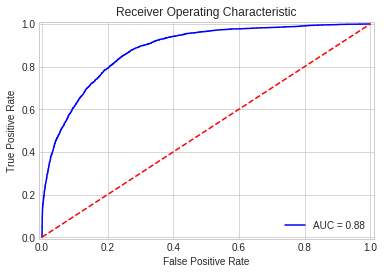

In [ ]:
plot_roc_curve(y_test, probs_log)

### 30. Do similar task with other ML algorithms: kNN, Gaussian Naive Bayes, Linear SVC, SGDClassifier, Decision Tree, Random Forest, Gradient Boosting Machine

kNN

In [ ]:
# K-Nearest Neighbor
start_time= time.time()
train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn = fit_ml_algo(KNeighborsClassifier(n_neighbors=2,n_jobs=-1),
                                                                            X_train,
                                                                            y_train,
                                                                            X_test,
                                                                            10)
knn_time= (time.time()-start_time)
print("Accuracy: %s" %acc_knn)
print("Accuracy CV 10-Fold %s" %acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 82.01
Accuracy CV 10-Fold 81.52
Running Time: 0:00:05.289290


In [ ]:
print(metrics.classification_report(y_train,train_pred_knn))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     24720
           1       0.69      0.41      0.52      7841

   micro avg       0.82      0.82      0.82     32561
   macro avg       0.77      0.68      0.70     32561
weighted avg       0.80      0.82      0.80     32561



In [ ]:
print(metrics.classification_report(y_test,test_pred_knn))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     12435
           1       0.70      0.42      0.52      3847

   micro avg       0.82      0.82      0.82     16282
   macro avg       0.77      0.68      0.71     16282
weighted avg       0.81      0.82      0.80     16282



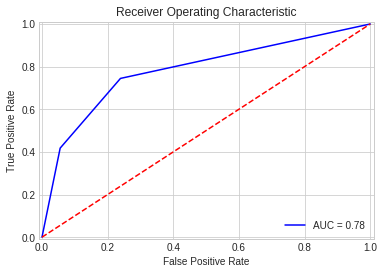

In [ ]:
plot_roc_curve(y_test, probs_knn)

Gaussian Naive Bayes

In [ ]:
# Gaussian Naive Bayes
start_time= time.time()
train_pred_nb, test_pred_nb, acc_nb, acc_cv_nb, probs_nb = fit_ml_algo(GaussianNB(),
                                                                            X_train,
                                                                            y_train,
                                                                            X_test,
                                                                            10)
nb_time= (time.time()-start_time)
print("Accuracy: %s" %acc_nb)
print("Accuracy CV 10-Fold %s" %acc_cv_nb)
print("Running Time: %s" % datetime.timedelta(seconds=nb_time))

Accuracy: 81.96
Accuracy CV 10-Fold 82.02
Running Time: 0:00:00.285662


In [ ]:
print(metrics.classification_report(y_train,train_pred_nb))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     24720
           1       0.64      0.59      0.61      7841

   micro avg       0.82      0.82      0.82     32561
   macro avg       0.75      0.74      0.75     32561
weighted avg       0.82      0.82      0.82     32561



In [ ]:
print(metrics.classification_report(y_test,test_pred_nb))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     12435
           1       0.63      0.58      0.60      3847

   micro avg       0.82      0.82      0.82     16282
   macro avg       0.75      0.74      0.74     16282
weighted avg       0.82      0.82      0.82     16282



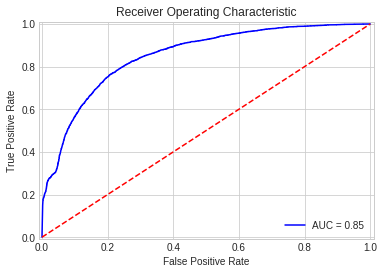

In [ ]:
plot_roc_curve(y_test, probs_nb)

Linear Support Vector Machine

In [ ]:
# Linear SVM
start_time= time.time()
train_pred_svm, test_pred_svm, acc_svm, acc_cv_svm,_ = fit_ml_algo(LinearSVC(),
                                                                            X_train,
                                                                            y_train,
                                                                            X_test,
                                                                            10)
svm_time= (time.time()-start_time)
print("Accuracy: %s" %acc_svm)
print("Accuracy CV 10-Fold %s" %acc_cv_svm)
print("Running Time: %s" % datetime.timedelta(seconds=svm_time))

Accuracy: 82.3
Accuracy CV 10-Fold 76.68
Running Time: 0:00:38.253884


In [ ]:
print(metrics.classification_report(y_train,train_pred_svm))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     24720
           1       0.52      0.52      0.52      7841

   micro avg       0.77      0.77      0.77     32561
   macro avg       0.68      0.68      0.68     32561
weighted avg       0.77      0.77      0.77     32561



In [ ]:
print(metrics.classification_report(y_test,test_pred_svm))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89     12435
           1       0.66      0.52      0.58      3847

   micro avg       0.82      0.82      0.82     16282
   macro avg       0.76      0.72      0.73     16282
weighted avg       0.81      0.82      0.82     16282



SGD Classifier

In [ ]:
# SGD Classifier
start_time= time.time()
train_pred_sgd, test_pred_sgd, acc_sgd, acc_cv_sgd,_ = fit_ml_algo(SGDClassifier(n_jobs=-1),
                                                                            X_train,
                                                                            y_train,
                                                                            X_test,
                                                                            10)
sgd_time= (time.time()-start_time)
print("Accuracy: %s" %acc_sgd)
print("Accuracy CV 10-Fold %s" %acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 79.38
Accuracy CV 10-Fold 75.05
Running Time: 0:00:00.529880


In [ ]:
print(metrics.classification_report(y_train,train_pred_sgd))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84     24720
           1       0.48      0.46      0.47      7841

   micro avg       0.75      0.75      0.75     32561
   macro avg       0.66      0.65      0.65     32561
weighted avg       0.75      0.75      0.75     32561



In [ ]:
print(metrics.classification_report(y_test,test_pred_sgd))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88     12435
           1       0.95      0.13      0.23      3847

   micro avg       0.79      0.79      0.79     16282
   macro avg       0.87      0.57      0.56     16282
weighted avg       0.83      0.79      0.73     16282



Decision Tree

In [ ]:
# Decision Tree Classifier
start_time= time.time()
train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt = fit_ml_algo(DecisionTreeClassifier(),
                                                                            X_train,
                                                                            y_train,
                                                                            X_test,
                                                                            10)
dt_time= (time.time()-start_time)
print("Accuracy: %s" %acc_dt)
print("Accuracy CV 10-Fold %s" %acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 82.18
Accuracy CV 10-Fold 81.9
Running Time: 0:00:01.325181


In [ ]:
print(metrics.classification_report(y_train,train_pred_dt))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     24720
           1       0.63      0.60      0.61      7841

   micro avg       0.82      0.82      0.82     32561
   macro avg       0.75      0.74      0.75     32561
weighted avg       0.82      0.82      0.82     32561



In [ ]:
print(metrics.classification_report(y_test,test_pred_dt))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88     12435
           1       0.63      0.60      0.62      3847

   micro avg       0.82      0.82      0.82     16282
   macro avg       0.75      0.75      0.75     16282
weighted avg       0.82      0.82      0.82     16282



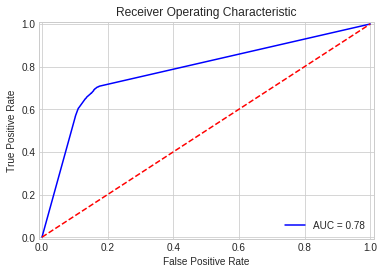

In [ ]:
plot_roc_curve(y_test, probs_dt)

Random Forest

In [ ]:
#RandomSearch for Hyperparameters
param_dist= {"max_depth": [10, None],
             "max_features": sp_randint(1,11),
             "min_samples_split": sp_randint(2,20),
             "min_samples_leaf": sp_randint(1,11),
             "bootstrap": [True, False],
             "criterion": ['gini','entropy']}
n_iter_search=10
rfc = RandomForestClassifier(n_estimators=10)
random_search=RandomizedSearchCV(rfc,
                                 n_jobs=-1,
                                 param_distributions=param_dist,
                                 n_iter=n_iter_search)
start=time.time()
random_search.fit(X_train,y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      "parameter setting." %((time.time()-start),n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 7.77 seconds for 10 candidatesparameter setting.
Model with rank: 1
Mean validation score: 0.863 (std: 0.004
Parameters: {'bootstrap': True, 'min_samples_leaf': 10, 'min_samples_split': 14, 'criterion': 'gini', 'max_features': 6, 'max_depth': 10}

Model with rank: 2
Mean validation score: 0.862 (std: 0.004
Parameters: {'bootstrap': False, 'min_samples_leaf': 6, 'min_samples_split': 10, 'criterion': 'gini', 'max_features': 9, 'max_depth': 10}

Model with rank: 3
Mean validation score: 0.862 (std: 0.004
Parameters: {'bootstrap': False, 'min_samples_leaf': 6, 'min_samples_split': 8, 'criterion': 'gini', 'max_features': 10, 'max_depth': 10}

Model with rank: 4
Mean validation score: 0.862 (std: 0.004
Parameters: {'bootstrap': True, 'min_samples_leaf': 4, 'min_samples_split': 16, 'criterion': 'entropy', 'max_features': 5, 'max_depth': 10}

Model with rank: 5
Mean validation score: 0.862 (std: 0.003
Parameters: {'bootstrap': True, 'min_samples_leaf': 6, 'min_samples_s

In [ ]:
# Random Forest Classifier
start_time= time.time()
train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf = fit_ml_algo(RandomForestClassifier(min_samples_leaf=5,min_samples_split=2,bootstrap=False, criterion='gini',max_features=5, max_depth=10),
                                                                            X_train,
                                                                            y_train,
                                                                            X_test,
                                                                            10)
rf_time= (time.time()-start_time)
print("Accuracy: %s" %acc_rf)
print("Accuracy CV 10-Fold %s" %acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))

Accuracy: 86.31
Accuracy CV 10-Fold 86.24
Running Time: 0:00:03.051832


In [ ]:
print(metrics.classification_report(y_train,train_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     24720
           1       0.78      0.59      0.67      7841

   micro avg       0.86      0.86      0.86     32561
   macro avg       0.83      0.77      0.79     32561
weighted avg       0.86      0.86      0.86     32561



In [ ]:
print(metrics.classification_report(y_test,test_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     12435
           1       0.78      0.59      0.67      3847

   micro avg       0.86      0.86      0.86     16282
   macro avg       0.83      0.77      0.79     16282
weighted avg       0.86      0.86      0.86     16282



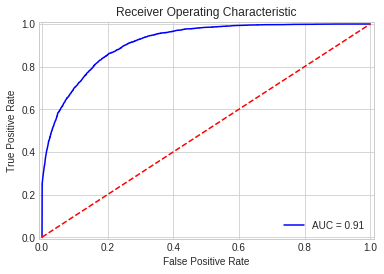

In [ ]:
plot_roc_curve(y_test, probs_rf)

Gradient Boosting Machine

In [ ]:
# Gradient Boosting Classifier
start_time= time.time()
train_pred_gb, test_pred_gb, acc_gb, acc_cv_gb, probs_gb = fit_ml_algo(GradientBoostingClassifier(),
                                                                            X_train,
                                                                            y_train,
                                                                            X_test,
                                                                            10)
gb_time= (time.time()-start_time)
print("Accuracy: %s" %acc_gb)
print("Accuracy CV 10-Fold %s" %acc_cv_gb)
print("Running Time: %s" % datetime.timedelta(seconds=gb_time))

Accuracy: 86.72
Accuracy CV 10-Fold 86.64
Running Time: 0:00:18.447782


In [ ]:
print(metrics.classification_report(y_train,train_pred_gb))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92     24720
           1       0.79      0.61      0.69      7841

   micro avg       0.87      0.87      0.87     32561
   macro avg       0.84      0.78      0.80     32561
weighted avg       0.86      0.87      0.86     32561



In [ ]:
print(metrics.classification_report(y_test,test_pred_gb))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92     12435
           1       0.79      0.60      0.68      3847

   micro avg       0.87      0.87      0.87     16282
   macro avg       0.84      0.77      0.80     16282
weighted avg       0.86      0.87      0.86     16282



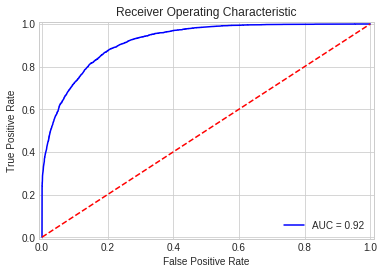

In [ ]:
plot_roc_curve(y_test, probs_gb)

Ranking the algorithm

In [ ]:
models = pd.DataFrame({
    'Algorithms': ['Logistic Regression', 'KNN', "Naive Bayes", "Stochastic Gradient Descent", "Linear SVC", "Decision Tree", "Random Forest", "Gradient Boosting Trees"],
    'Accuracy_Score': [acc_log,acc_knn, acc_nb, acc_sgd, acc_svm, acc_dt, acc_rf, acc_gb]
})
models.sort_values(by='Accuracy_Score', ascending =False)

,Accuracy_Score,Algorithms
7,86.72,Gradient Boosting Trees
6,86.31,Random Forest
0,83.78,Logistic Regression
4,82.30,Linear SVC
5,82.18,Decision Tree
1,82.01,KNN
2,81.96,Naive Bayes
3,79.38,Stochastic Gradient Descent


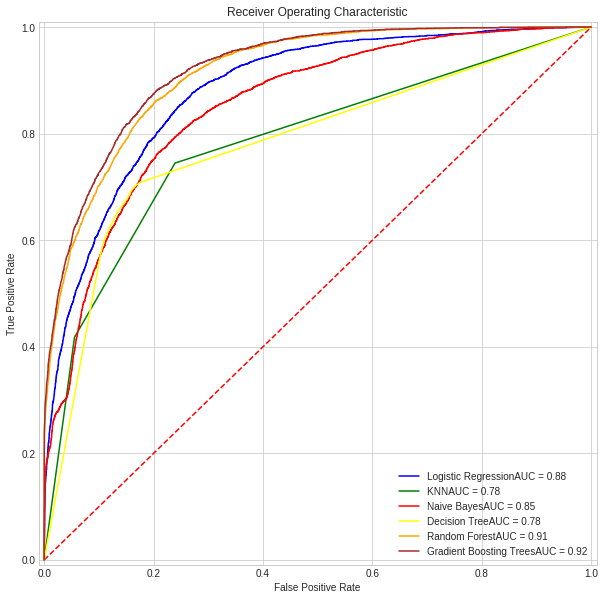

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10))

models=[
 'Logistic Regression', 'KNN', "Naive Bayes",  "Decision Tree", "Random Forest", "Gradient Boosting Trees"
]
probs=[probs_log,probs_knn,probs_nb,probs_dt,probs_rf,probs_gb]
colors=['blue','green','red','yellow','orange','brown']

plt.title('Receiver Operating Characteristic')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

def plot_roc_curve(y_test, prob, model):
  fpr, tpr, threshold = metrics.roc_curve(y_test,prob)
  roc_auc= metrics.auc(fpr,tpr)
  plt.plot(fpr, tpr, 'b', label = model + 'AUC = %0.2f' % roc_auc, color=colors[i])
  plt.legend(loc = 'lower right')

for i,model in list(enumerate(models)):
  plot_roc_curve(y_test, probs[i], models[i])

plt.show()

=> Gradient Boosting Tree and Random Forest are the best fit models to this data